In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import pyfixest as pf
import warnings
warnings.filterwarnings("ignore")

In [2]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

In [3]:
# Losses from Natural Disasters Database
lnd = pd.read_csv(os.path.join(project_dir,'data','raw','lnd_full_clean_2024-12-31.csv'))
lnd = lnd[lnd['weight_type']=='Population']
lnd = lnd[lnd['fips'].notnull()]
lnd['county'] = lnd['fips'].astype(int)
lnd['begin_date'] = pd.to_datetime(lnd['begin_date'])
lnd['year'] = lnd['begin_date'].dt.year

cnty_dmg = lnd.groupby(['county','begin_date','disaster_group'])[['damages_total_adj']].sum() # sum damage
cnty_dmg_ds = xr.Dataset.from_dataframe(cnty_dmg).resample(begin_date='1ME').sum() # aggregrate to monthly scale
cnty_dmg_ds = cnty_dmg_ds.rename({"begin_date":"time"})

In [3]:
cnty_gdp_old = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_gdp_01-23.csv'), encoding="latin1")
cnty_gdp_old = cnty_gdp_old[cnty_gdp_old['Description']=='Real GDP (thousands of chained 2017 dollars) ']
cnty_gdp_old_long = cnty_gdp_old.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='gdp')
cnty_gdp_old_long = cnty_gdp_old_long[cnty_gdp_old_long['GeoName'].str.contains(",")]
cnty_gdp_old_long['gdp'] = cnty_gdp_old_long['gdp'].replace({"(NA)":np.nan})
cnty_gdp_old_long['gdp'] = 1e3*cnty_gdp_old_long['gdp'].astype(float)
cnty_gdp_old_long['year'] = cnty_gdp_old_long['year'].astype(int)
cnty_gdp_old_long = cnty_gdp_old_long.rename(columns={"gdp":"gdp_old"})

In [4]:
cnty_gdp = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_gdp_2001-2024.csv'), encoding="latin1")
cnty_gdp = cnty_gdp[cnty_gdp['Description']=='Real GDP (thousands of chained 2017 dollars) ']
cnty_gdp_long = cnty_gdp.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2025)],var_name='year',value_name='gdp')
cnty_gdp_long = cnty_gdp_long[cnty_gdp_long['GeoName'].str.contains(",")]
cnty_gdp_long['GeoFIPS'] = cnty_gdp_long['GeoFIPS'].apply(lambda s: int(s.replace('"','')))
cnty_gdp_long['gdp'] = cnty_gdp_long['gdp'].replace({"(NA)":np.nan})
cnty_gdp_long['gdp'] = 1e3*cnty_gdp_long['gdp'].astype(float)
cnty_gdp_long['year'] = cnty_gdp_long['year'].astype(int)

cnty_sum = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_income_1969-2024.csv'), encoding="latin1")
cnty_pop = cnty_sum[cnty_sum['Description']==' Population (persons) 3/']
cnty_pop_long = cnty_pop.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2025)],var_name='year',value_name='pop')
cnty_pop_long = cnty_pop_long[cnty_pop_long['GeoName'].str.contains(",")]
cnty_pop_long['GeoFIPS'] = cnty_pop_long['GeoFIPS'].apply(lambda s: int(s.replace('"','')))
cnty_pop_long['pop'] = cnty_pop_long['pop'].replace({"(NA)":np.nan})
cnty_pop_long['pop'] = cnty_pop_long['pop'].astype(float)
cnty_pop_long['year'] = cnty_pop_long['year'].astype(int)

# cnty_inc = cnty_sum[cnty_sum['Description']=='Personal income (thousands of dollars) ']
# cnty_inc_long = cnty_inc.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='inc')
# cnty_inc_long = cnty_inc_long[cnty_inc_long['GeoName'].str.contains(",")]
# cnty_inc_long['inc'] = cnty_inc_long['inc'].replace({"(NA)":np.nan})
# cnty_inc_long['inc'] = 1e3*cnty_inc_long['inc'].astype(float)
# cnty_inc_long['year'] = cnty_inc_long['year'].astype(int)

# cnty_inc_pc = cnty_sum[cnty_sum['Description']=='Per capita personal income (dollars) 2/']
# cnty_inc_pc_long = cnty_inc_pc.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='inc_pc')
# cnty_inc_pc_long = cnty_inc_pc_long[cnty_inc_pc_long['GeoName'].str.contains(",")]
# cnty_inc_pc_long['inc_pc'] = cnty_inc_pc_long['inc_pc'].replace({"(NA)":np.nan})
# cnty_inc_pc_long['inc_pc'] = cnty_inc_pc_long['inc_pc'].astype(float)
# cnty_inc_pc_long['year'] = cnty_inc_pc_long['year'].astype(int)

cnty_data = cnty_gdp_long.merge(cnty_pop_long[['GeoFIPS','year','pop']],on=['GeoFIPS','year'])#.merge(cnty_inc_long[['GeoFIPS','year','inc']],on=['GeoFIPS','year']).merge(cnty_inc_pc_long[['GeoFIPS','year','inc_pc']],on=['GeoFIPS','year'])
cnty_data['gdppc'] = cnty_data['gdp']/cnty_data['pop']
cnty_data = cnty_data.rename(columns={"GeoFIPS":"county"})

In [5]:
cnty_gdp_comp = cnty_gdp_long.merge(cnty_gdp_old_long,on=['GeoFIPS','year'])

In [6]:
cnty_gdp_comp['agree'] = cnty_gdp_comp['gdp']==cnty_gdp_comp['gdp_old']

In [7]:
cnty_gdp_comp['diff'] = cnty_gdp_comp['gdp']-cnty_gdp_comp['gdp_old']

In [19]:
cnt

NameError: name 'cnty' is not defined

In [49]:
import geopandas as gpd
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))
gdf_state = gdf.dissolve(by='state')
tot_diff = cnty_gdp_comp.groupby("GeoFIPS",as_index=False)[['diff','gdp_old']].sum().rename(columns={"GeoFIPS":"county"})
tot_diff = gdf.merge(tot_diff,on='county')


In [51]:
tot_diff['diff_pct'] = 100*tot_diff['diff']/tot_diff['gdp_old']

In [53]:
tot_diff.sort_values("diff_pct")

,county,name,state,geometry,diff,gdp_old,diff_pct
1524,13305,Wayne County,GA,"POLYGON ((-82.13269 31.47139, -82.13371 31.651...",-1.878071e+09,2.392270e+10,-7.850581
630,30075,Powder River County,MT,"POLYGON ((-106.0248 45.0001, -106.10432 45.000...",-9.622800e+07,1.615667e+09,-5.955930
1509,12077,Liberty County,FL,"POLYGON ((-84.93346 30.60637, -84.88331 30.605...",-2.299510e+08,5.068894e+09,-4.536512
580,53039,Klickitat County,WA,"POLYGON ((-119.86692 45.84635, -119.9342 45.83...",-9.467840e+08,2.438037e+10,-3.883387
2308,32029,Storey County,NV,"POLYGON ((-119.28362 39.62156, -119.47857 39.3...",-4.045970e+08,2.110242e+10,-1.917302
...,...,...,...,...,...,...,...
385,48301,Loving County,TX,"POLYGON ((-103.732 32.00147, -103.50988 32.001...",1.363017e+09,4.703208e+10,2.898058
2699,48317,Martin County,TX,"POLYGON ((-102.21124 32.08679, -102.21103 32.2...",1.753511e+09,6.019368e+10,2.913115
2657,47143,Rhea County,TN,"POLYGON ((-85.13519 35.45864, -85.11599 35.475...",1.135796e+09,3.582247e+10,3.170625
173,13029,Bryan County,GA,"POLYGON ((-81.16127 31.73683, -81.17138 31.736...",1.012046e+09,1.848942e+10,5.473649


In [26]:
thresh = [-1e10,-5e9,-1e9,-5e8,-1e8,-5e7,-1e7,1e7,5e7,1e8,5e8,1e9,5e9,1e10]

In [89]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs

diff_cols = sns.color_palette("RdBu",len(thresh)+1)
diff_cols[7]='white'
diff_cmap = mpl.colors.ListedColormap(diff_cols[1:-1])
diff_cmap.set_under(diff_cols[0])
diff_cmap.set_over(diff_cols[-1])
diff_norm = mpl.colors.BoundaryNorm(thresh,ncolors=len(diff_cols)-2)

In [57]:
diff_pct_levels = np.linspace(-3,3,13)
diff_pct_cols = sns.color_palette("RdBu",len(diff_pct_levels)+1)
diff_pct_cols[7]='white'
diff_pct_cmap = mpl.colors.ListedColormap(diff_pct_cols[1:-1])
diff_pct_cmap.set_under(diff_pct_cols[0])
diff_pct_cmap.set_over(diff_pct_cols[-1])
diff_pct_norm = plt.Normalize(vmin=-3,vmax=3)

Text(0.5, 0, 'New - old (%)')

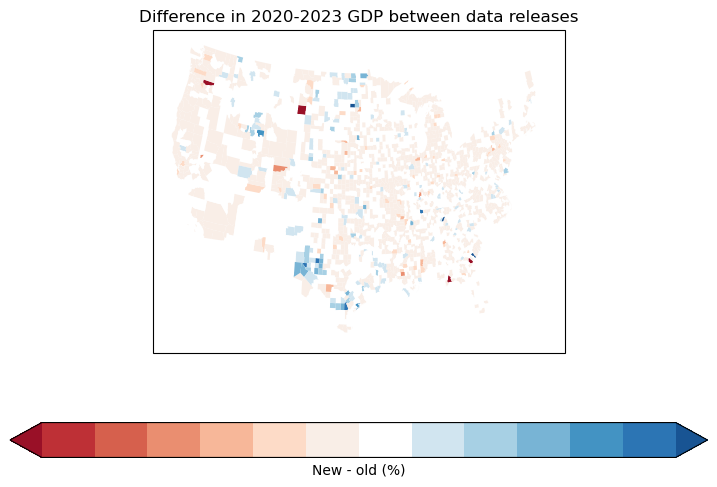

In [87]:
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(nrows=1,ncols=1,figure=fig)
ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
tot_diff.plot(ax=ax1,transform=ccrs.PlateCarree(),column='diff_pct',cmap=diff_pct_cmap,norm=diff_pct_norm)
ax1.title.set_text("Difference in 2020-2023 GDP between data releases")
diff_pct_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=diff_pct_norm,cmap=diff_pct_cmap),ax=ax1,orientation='horizontal',ticks=thresh,extend='both',shrink=0.9)
diff_pct_cbar.ax.set_xlabel('New - old (%)')


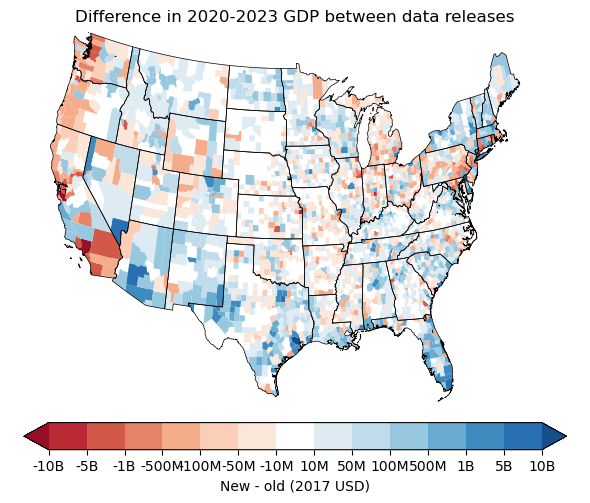

In [91]:
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(nrows=1,ncols=1,figure=fig)
ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
tot_diff.plot(ax=ax1,transform=ccrs.PlateCarree(),column='diff',cmap=diff_cmap,norm=diff_norm)
ax1.title.set_text("Difference in 2020-2023 GDP between data releases")
diff_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=diff_norm,cmap=diff_cmap),ax=ax1,orientation='horizontal',ticks=thresh,extend='both',shrink=0.7,pad=0)
diff_cbar.ax.set_xlabel('New - old (2017 USD)')
diff_cbar.ax.set_xticklabels(['-10B','-5B','-1B','-500M','-100M','-50M','-10M','10M','50M','100M','500M','1B','5B','10B'])
ax1.set_extent([-123, -68, 24, 49],ccrs.PlateCarree())
ax1.set_frame_on(False)
gdf_state.geometry.boundary.plot(ax=ax1,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.5)
plt.show()

<Axes: >

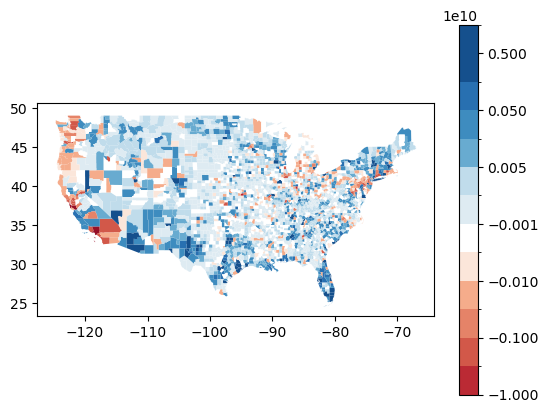

In [37]:
tot_diff.plot(column='diff',cmap=diff_cmap,norm=diff_norm,legend=True)

In [ ]:
cnty_gdp_old_long = cnty_gdp_old_long.rename(columns={"gdp":"gdp_old"})

In [30]:
cnty_gdp_ds = xr.Dataset.from_dataframe(cnty_gdp_long.set_index(['GeoFIPS','year']))
cnty_gdp_ds['year'] = cnty_gdp_ds['year'].astype(int)
cnty_gdp_ds['growth'] = np.log(cnty_gdp_ds['gdp'])-np.log(cnty_gdp_ds['gdp'].shift(year=1))

In [27]:
st_gdp_ds = xr.Dataset.from_dataframe(cnty_gdp_long_st.set_index(['GeoFIPS','year']))
st_gdp_ds['year'] = st_gdp_ds['year'].astype(int)
st_gdp_ds['growth'] = np.log(st_gdp_ds['gdp'])-np.log(st_gdp_ds['gdp'].shift(year=1))

In [31]:
states = st_gdp_ds['GeoFIPS'].values
data_2d = st_gdp_ds['growth'].sel(year=slice(2002,2023)).transpose("year", "GeoFIPS").values 
corr_matrix = np.corrcoef(data_2d, rowvar=False)  # shape: (n_states, n_states)

# Extract upper triangle without diagonal
i_upper, j_upper = np.triu_indices(len(states), k=1)
corr_df_state = pd.DataFrame({
    "state1": states[i_upper],
    "state2": states[j_upper],
    "correlation": corr_matrix[i_upper, j_upper]
})

# state_dict = dict(zip(mod_mat['county'],mod_mat['state']))
# corr_df['state1'] = corr_df['region1'].map(state_dict)
# corr_df['state2'] = corr_df['region2'].map(state_dict)

In [35]:
counties = cnty_gdp_ds['GeoFIPS'].values
data_2d = cnty_gdp_ds['growth'].sel(year=slice(2002,2023)).transpose("year", "GeoFIPS").values 
corr_matrix = np.corrcoef(data_2d, rowvar=False)  # shape: (n_states, n_states)

# Extract upper triangle without diagonal
i_upper, j_upper = np.triu_indices(len(counties), k=1)
corr_df_county = pd.DataFrame({
    "county1": counties[i_upper],
    "county2": counties[j_upper],
    "correlation": corr_matrix[i_upper, j_upper]
})



In [43]:
cnty_gdp_long_cnty['state'] = cnty_gdp_long_cnty['GeoName'].apply(lambda s: s.replace("*","").split(",")[-1])
state_dict = dict(zip(cnty_gdp_long_cnty['GeoFIPS'],cnty_gdp_long_cnty['state']))
corr_df_county['state1'] = corr_df_county['county1'].map(state_dict)
corr_df_county['state2'] = corr_df_county['county2'].map(state_dict)

<Axes: >

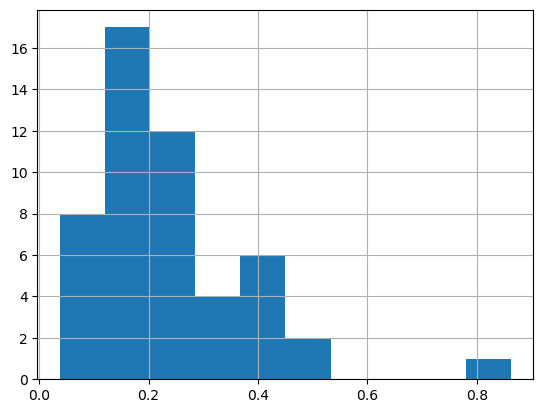

In [48]:
corr_df_county[corr_df_county.state1==corr_df_county.state2].groupby("state1")['correlation'].mean().hist()

<Axes: >

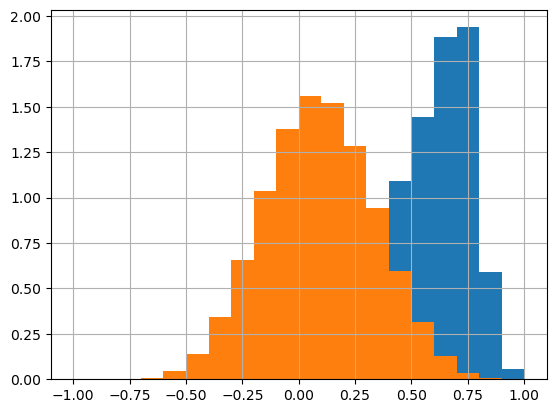

In [37]:
corr_df_state['correlation'].hist(density=True,bins=np.arange(-1,1.1,0.1))
corr_df_county['correlation'].hist(density=True,bins=np.arange(-1,1.1,0.1))

In [12]:
dict(zip(cnty_gdp_long_st.GeoFIPS,cnty_gdp_long_st.GeoName))

{1000: 'Alabama',
 2000: 'Alaska',
 4000: 'Arizona',
 5000: 'Arkansas',
 6000: 'California',
 8000: 'Colorado',
 9000: 'Connecticut',
 10000: 'Delaware',
 11000: 'District of Columbia',
 12000: 'Florida',
 13000: 'Georgia',
 15000: 'Hawaii',
 16000: 'Idaho',
 17000: 'Illinois',
 18000: 'Indiana',
 19000: 'Iowa',
 20000: 'Kansas',
 21000: 'Kentucky',
 22000: 'Louisiana',
 23000: 'Maine',
 24000: 'Maryland',
 25000: 'Massachusetts',
 26000: 'Michigan',
 27000: 'Minnesota',
 28000: 'Mississippi',
 29000: 'Missouri',
 30000: 'Montana',
 31000: 'Nebraska',
 32000: 'Nevada',
 33000: 'New Hampshire',
 34000: 'New Jersey',
 35000: 'New Mexico',
 36000: 'New York',
 37000: 'North Carolina',
 38000: 'North Dakota',
 39000: 'Ohio',
 40000: 'Oklahoma',
 41000: 'Oregon',
 42000: 'Pennsylvania',
 44000: 'Rhode Island',
 45000: 'South Carolina',
 46000: 'South Dakota',
 47000: 'Tennessee',
 48000: 'Texas',
 49000: 'Utah',
 50000: 'Vermont',
 51000: 'Virginia',
 53000: 'Washington',
 54000: 'West Virg

In [10]:
cnty_gdp_long_st = cnty_gdp_long_st[cnty_gdp_long_st.GeoFIPS!=0]
cnty_gdp_long_st[

,GeoFIPS,GeoName,year,gdp
1,1000,Alabama,2001,168448296
69,2000,Alaska,2001,40014380
104,4000,Arizona,2001,230885564
120,5000,Arkansas,2001,95528730
196,6000,California,2001,1784567677
...,...,...,...,...
73089,94000,Plains,2023,1388150705
73090,95000,Southeast,2023,4952758909
73091,96000,Southwest,2023,2838599111
73092,97000,Rocky Mountain,2023,856063087


In [5]:
cnty_data['state'] = cnty_data['GeoName'].apply(lambda s: s.split(", ")[-1].replace("*",""))
state_dict = dict(zip(cnty_data.county,cnty_data.state))
lnd['state'] = lnd['county'].map(state_dict)

In [100]:
dmg_df = cnty_dmg_ds.sel(disaster_group='Flood')['damages_total_adj'].groupby("time.year").sum().to_dataframe().reset_index().merge(cnty_data,on='county')
dmg_tot = dmg_df.groupby("county")[['damages_total_adj','gdp']].sum()
dmg_tot['damage_pct'] = 100*dmg_tot['damages_total_adj']/dmg_tot['gdp']

In [5]:
cnty_ds = xr.Dataset.from_dataframe(cnty_data.set_index(['county','year']))
cnty_ds['growth'] = 100*(np.log(cnty_ds['gdppc'])-np.log(cnty_ds['gdppc'].shift(year=1)))
cnty_ds['growth_lag1'] = cnty_ds['growth'].shift(year=1)


cnty_typ = pd.read_csv(os.path.join(project_dir,'data','raw','econ','erscountytypology2025edition.csv')).rename(columns={"FIPStxt":"county","Metro2023":"metro"})
cnty_typ_wide = cnty_typ.pivot(index='county',columns='Attribute',values='Value')
attr_ds = xr.Dataset.from_dataframe(cnty_typ_wide)
metro_ds = xr.Dataset.from_dataframe(cnty_typ.groupby("county")[['metro']].first())
attr_ds['metro'] = metro_ds['metro']

# cnty_ds = xr.merge([cnty_ds,attr_ds])

In [102]:
# FEMA disaster declarations 
dis_dec = pd.read_csv(os.path.join(project_dir,'data','raw','DisasterDeclarationsSummaries.csv'))
dis_dec = dis_dec[dis_dec['fipsCountyCode']!=0]
dis_dec['county'] = dis_dec['fipsStateCode'].astype(str)+dis_dec['fipsCountyCode'].astype(str).str.zfill(3)
dis_dec['county'] = dis_dec['county'].astype(int)
dis_dec = dis_dec.rename(columns={"fyDeclared":"year"})
dis_dec['decl'] = 1
dis_dec = dis_dec[dis_dec['year']>=2003]
dis_dec['flood_decl_notc'] = ((dis_dec['declarationTitle'].str.contains("FLOOD"))|(dis_dec['designatedIncidentTypes'].str.contains("F"))).astype(int)
dis_dec['flood_decl_incltc'] = ((dis_dec['declarationTitle'].str.contains("FLOOD"))|(dis_dec['designatedIncidentTypes'].str.contains("F"))|(dis_dec['incidentType']=='Hurricane')).astype(int)
dis_dec.loc[dis_dec['declarationTitle'].str.contains("EVACUATION"),'flood_decl_incltc']=0
dis_dec.loc[dis_dec['declarationTitle'].str.contains("EVACUEES"),'flood_decl_incltc']=0
dis_dec_ann = dis_dec.groupby(['county','year'])[['flood_decl_notc','flood_decl_incltc']].sum()
dis_dec_ds = xr.Dataset.from_dataframe(dis_dec_ann).fillna(0)
cnty_ds['flood_decl_notc'] = dis_dec_ds['flood_decl_notc'].clip(max=1)
cnty_ds['flood_decl_incltc'] = dis_dec_ds['flood_decl_incltc'].clip(max=1)

In [103]:
cnty_ds['flood_decl_notc_lag1'] = cnty_ds['flood_decl_notc'].shift(year=1)
cnty_ds['flood_decl_incltc_lag1'] = cnty_ds['flood_decl_incltc'].shift(year=1)

In [42]:
def antecedent(ts,m):
    if np.isnan(m):
        return np.nan
    return ts[int(m)-1]

clim_mon = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county','imerg_grace-csr_mon.nc'))
clim_mon['county'] = clim_mon['county'].astype(int)
clim_mon['flood'] = cnty_dmg_ds['damages_total_adj'].sel(disaster_group='Flood')>1e5
clim_mon['flood_dmg'] = cnty_dmg_ds['damages_total_adj'].sel(disaster_group='Flood')
p_exc_max = clim_mon['p_exc'].groupby("time.year").max()
p_exc_max.name = 'p_exc_max'
pexcmax_m = clim_mon['p_exc'].groupby("time.year").apply(lambda g: g.idxmax("time").dt.month)
tws_def_pre = xr.apply_ufunc(antecedent,
                          clim_mon['tws_def_ant'].groupby("time.year"),
                          pexcmax_m,
                          input_core_dims=[['time'],[]],
                          vectorize=True)
tws_def_pre.name = 'tws_def_pre_pexcmax'

rxmon = xr.apply_ufunc(antecedent,
                        clim_mon['ppt'].groupby("time.year"),
                          # clim_mon['rain'].groupby("time.year"),
                          pexcmax_m,
                          input_core_dims=[['time'],[]],
                          vectorize=True)
rxmon.name = 'rxmon'

rxmon_ann = clim_mon['ppt'].groupby("time.year").max()
rxmon_ann.name='rxmon_ann'

# wind_m = xr.apply_ufunc(antecedent,
#                           clim_mon['wind_speed'].groupby("time.year"),
#                           pexcmax_m,
#                           input_core_dims=[['time'],[]],
#                           vectorize=True)
# wind_m.name = 'wind_max'

rx_df = xr.merge([rxmon,tws_def_pre,rxmon_ann])

# rx_df = xr.merge([rxmon,tws_def_pre,wind_m])
rx_df['rxmon_sq'] = np.power(rx_df['rxmon'],2)
rx_df['rxmon_lag1'] = rx_df['rxmon'].shift(year=1)
rx_df['rxmon_sq_lag1'] = rx_df['rxmon_sq'].shift(year=1)
rx_df['tws_def_pre_pexcmax_lag1'] = rx_df['tws_def_pre_pexcmax'].shift(year=1)

rx_df = rx_df.to_dataframe().reset_index()


In [43]:
clim = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county','imerg_grace-csr.nc'))
clim['county'] = clim['county'].astype(int)
clim['p_exc_rxmon'] = clim['p_exc_rxmon']/10
clim['ppt_ann'] = clim['ppt_ann']
# clim['p_exc_rxmon_sq'] = np.power(clim['p_exc_rxmon'],2)
# clim['p_exc_rxmon_cub'] = np.power(clim['p_exc_rxmon'],3)
# clim['ppt_ann_sq'] = np.power(clim['ppt_ann'],2)

n_lags = 3
vars_to_lag = ['ppt_ann','p_exc_rxmon',]
for v in vars_to_lag:
    clim[f'{v}_sq'] = np.power(clim[v],2)
    clim[f'{v}_cub'] = np.power(clim[v],3)
    clim[f'{v}_quart'] = np.power(clim[v],4)
    for l in np.arange(0,n_lags+1):
        clim[f'{v}_lag{l}'] = clim[v].shift(year=l)
        clim[f'{v}_sq_lag{l}'] = clim[f'{v}_sq'].shift(year=l)
        clim[f'{v}_cub_lag{l}'] = clim[f'{v}_cub'].shift(year=l)
        clim[f'{v}_quart_lag{l}'] = clim[f'{v}_quart'].shift(year=l)

temp = xr.open_dataset(os.path.join(project_dir,'data','processed','prism_temp_stats_county.nc')).rename({"tavg":"tmean"})
temp['county'] = temp['county'].astype(int)
vars_to_lag = ['tmean']
for v in vars_to_lag:
    temp[f'{v}_sq'] = np.power(temp[v],2)
    for l in np.arange(0,n_lags+1):
        temp[f'{v}_lag{l}'] = temp[v].shift(year=l)
        temp[f'{v}_sq_lag{l}'] = temp[f'{v}_sq'].shift(year=l)

In [38]:
rx1d = xr.open_dataset(os.path.join(project_dir,'data','processed','extreme_precip_stats','county','prism.nc'))
vars_to_lag = ['rx1d','rx5d','rxmon','r95p','r99p','r99p9']
for v in vars_to_lag:
    rx1d[f'{v}_sq'] = np.power(rx1d[v],2)
    for l in np.arange(0,n_lags+1):
        rx1d[f'{v}_lag{l}'] = rx1d[v].shift(year=l)
        rx1d[f'{v}_sq_lag{l}'] = rx1d[f'{v}_sq'].shift(year=l)

# rx1d['county'] = rx1d['county'].astype(int)
# rx1d = rx1d.drop(['band']).to_dataframe().reset_index()


In [39]:
rx1d_df = rx1d.drop(['band',]).to_dataframe().reset_index()

In [44]:
mod_mat = cnty_ds.to_dataframe().reset_index().merge(clim.to_dataframe().reset_index(),on=['county','year']).merge(rx_df,on=['county','year']).merge(temp.drop(['band','spatial_ref']).to_dataframe().reset_index(),on=['county','year'])

# mod_mat = cnty_ds.to_dataframe().reset_index().merge(clim.to_dataframe().reset_index(),on=['county','year']).merge(rx_df,on=['county','year']).merge(temp.drop(['band','spatial_ref']).to_dataframe().reset_index(),on=['county','year']).merge(rx1d_df,on=['county','year'])
# mod_mat = cnty_ds.to_dataframe().reset_index().merge(clim.drop(['spatial_ref']).to_dataframe().reset_index(),on=['county','year']).merge(temp_ann.drop(['band','spatial_ref']).to_dataframe().reset_index(),on=['county','year']).merge(rx_df,on=['county','year']).merge(rx1d,on=['county','year'])
mod_mat = mod_mat[mod_mat['GeoName'].notnull()]
mod_mat['state'] = mod_mat['GeoName'].apply(lambda s: s.split(", ")[-1])
mod_mat.loc[mod_mat['state']=='CO*','state']='CO'
mod_mat.loc[mod_mat['state']=='SD*','state']='SD'
mod_mat.loc[mod_mat['state']=='VA*','state']='VA'
mod_mat['t'] = mod_mat['year']-2003

reg_dict = {'AL':'SE', 'AZ':'SW', 'AR':"S", 'CA':"W", 'CO':"SW", 'CT':"NE",'DE':"NE", 'DC':"SE", 'FL':"SE", 'GA':"SE", 'ID':"NW", 'IL':"OV",
       'IN':"OV", 'IA':"UM", 'KS':"NR", 'KY':"OV", 'LA':"S", 'ME':"NE", 'MD':"NE", 'MA':"NE", 'MI':"UM", 'MN':"UM", 'MS':"S",
       'MO':"OV", 'MT':"NR", 'NE':"S", 'NV':"W", 'NH':"NE", 'NJ':"NE", 'NM':"SW", 'NY':"NE", 'NC':"SE", 'ND':"NR", 'OH':"OV",
       'OK':"S", 'OR':"NW", 'PA':"NE", 'RI':"NE", 'SC':"SE", 'SD':"NR", 'TN':"OV", 'TX':"S", 'UT':"SW", 'VT':"NE", 'VA':"SE",
       'WA':"NW", 'WV':"OV", 'WI':"UM", 'WY':"NR"}
mod_mat['region'] = mod_mat['state'].map(reg_dict)
# mod_mat.to_csv(os.path.join(project_dir,'data','processed','cpc_grace-csr_county_panel.csv'))

In [83]:
mod_mat = pd.read_csv(os.path.join(project_dir,'data','processed','panels','chirps_grace-jpl_county_panel.csv'))

In [58]:
mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','p_exc_rxmon','p_exc_rxmon_sq',]
# mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','C(p_exc_rxmon_cat)']
mod_vars = mod_vars + [f'{v}_lag1' for v in mod_vars]
mod_str = 'growth~'+'+'.join(mod_vars)+"|county+year"
mod_sq = pf.feols(mod_str,data=mod_mat)

In [59]:
mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','p_exc_rxmon','p_exc_rxmon_sq','p_exc_rxmon_cub']
# mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','C(p_exc_rxmon_cat)']
mod_vars = mod_vars + [f'{v}_lag1' for v in mod_vars]
mod_str = 'growth~'+'+'.join(mod_vars)+"|county+year"
mod_cub = pf.feols(mod_str,data=mod_mat)


In [60]:
mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','p_exc_rxmon','p_exc_rxmon_sq','p_exc_rxmon_cub','p_exc_rxmon_quart']
# mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','C(p_exc_rxmon_cat)']
mod_vars = mod_vars + [f'{v}_lag1' for v in mod_vars]
mod_str = 'growth~'+'+'.join(mod_vars)+"|county+year"
mod_quart = pf.feols(mod_str,data=mod_mat)


In [57]:
mod_cub.vcov({"CRV1":"state"}).summary()


###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  67621

| Coefficient     |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:----------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ppt_ann         |      0.002 |        0.002 |     0.709 |      0.482 | -0.003 |   0.006 |
| ppt_ann_sq      |     -0.000 |        0.000 |    -0.330 |      0.743 | -0.000 |   0.000 |
| tmean           |     -0.668 |        0.424 |    -1.576 |      0.122 | -1.521 |   0.184 |
| tmean_sq        |      0.040 |        0.016 |     2.502 |      0.016 |  0.008 |   0.073 |
| p_exc_rxmon     |      0.005 |        0.019 |     0.273 |      0.786 | -0.032 |   0.042 |
| p_exc_rxmon_sq  |     -0.001 |        0.000 |    -2.580 |      0.013 | -0.002 |  -0.000 |
| p_exc_rxmon_cub |     -0.000 |        0.000 |    -0.791 |      0.433 | -0.000 |   0.000 |
---
RMSE: 8.667 R2: 0.064 R2 Within: 0.001 


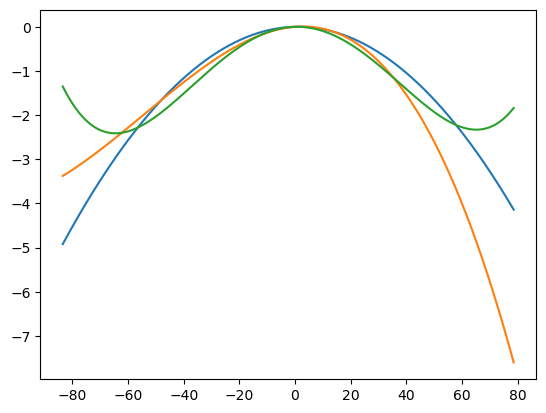

In [56]:


import matplotlib.pyplot as plt
ps = np.linspace(mod_mat['p_exc_rxmon'].min(),mod_mat['p_exc_rxmon'].max(),1000)
pred_sq = ps*mod_sq.coef()['p_exc_rxmon']+(ps**2)*mod_sq.coef()['p_exc_rxmon_sq']
pred_cub = ps*mod_cub.coef()['p_exc_rxmon']+(ps**2)*mod_cub.coef()['p_exc_rxmon_sq']+(ps**3)*mod_cub.coef()['p_exc_rxmon_cub']
pred_quart = ps*mod_quart.coef()['p_exc_rxmon']+(ps**2)*mod_quart.coef()['p_exc_rxmon_sq']+(ps**3)*mod_quart.coef()['p_exc_rxmon_cub']+(ps**4)*mod_quart.coef()['p_exc_rxmon_quart']
plt.plot(ps,pred_sq)
plt.plot(ps,pred_cub)
plt.plot(ps,pred_quart)
# plt.plot(ps,me0+me1)

In [11]:
mod.summary()

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  61774

| Coefficient         |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ppt_ann             |     -0.003 |        0.001 |    -2.192 |      0.028 | -0.005 |  -0.000 |
| ppt_ann_sq          |      0.000 |        0.000 |     2.677 |      0.007 |  0.000 |   0.000 |
| tmean               |     -0.599 |        0.162 |    -3.694 |      0.000 | -0.918 |  -0.281 |
| tmean_sq            |      0.025 |        0.007 |     3.702 |      0.000 |  0.012 |   0.038 |
| p_exc_rxmon         |      0.008 |        0.006 |     1.227 |      0.220 | -0.005 |   0.020 |
| p_exc_rxmon_sq      |     -0.001 |        0.000 |    -5.811 |      0.000 | -0.002 |  -0.001 |
| ppt_ann_lag1        |     -0.003 |        0.001 |    -2.327 |      0.020 | -0.005 |  -0.000 |
| ppt_ann_sq_lag1     |      

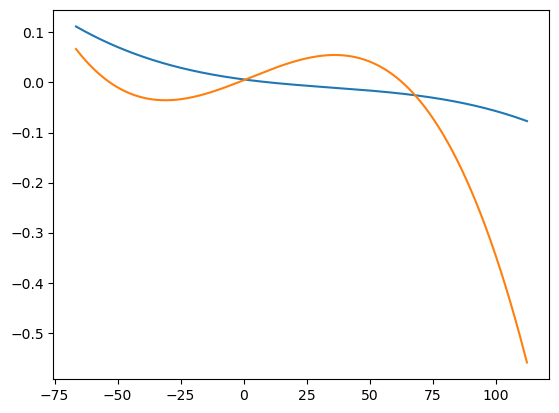

In [53]:
# mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','p_exc_rxmon','p_exc_rxmon_sq']
# mod_vars = mod_vars + [f'{v}_lag1' for v in mod_vars]
# mod_str = 'growth~'+'+'.join(mod_vars)+"|county+year"
mod = pf.feols(mod_str,data=mod_mat.dropna(subset=mod_vars+["growth"]))


import matplotlib.pyplot as plt
ps = np.linspace(mod_mat['p_exc_rxmon'].min(),mod_mat['p_exc_rxmon'].max(),1000)
me0 = mod.coef()['p_exc_rxmon']+2*ps*mod.coef()['p_exc_rxmon_sq']+3*np.power(ps,2)*mod.coef()['p_exc_rxmon_cub']+4*np.power(ps,3)*mod.coef()['p_exc_rxmon_quart']
# me1 = mod.coef()['p_exc_rxmon_lag1']+2*ps*mod.coef()['p_exc_rxmon_sq_lag1']+3*np.power(ps,2)*mod.coef()['p_exc_rxmon_cub_lag1']+4*np.power(ps,3)*mod.coef()['p_exc_rxmon_quart_lag1']
plt.plot(ps,me0)
plt.plot(ps,me0+me1)

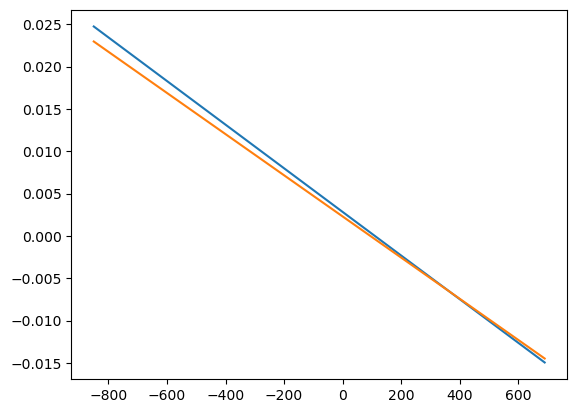

In [9]:

# mod_tr_str = 'growth~'+'+'.join(mod_vars)+"+i(county, t)|county+year"
# mod_tr = pf.feols(mod_tr_str,data=mod_mat.dropna(subset=mod_vars+["growth"]))


import matplotlib.pyplot as plt
ps = np.linspace(mod_mat['p_exc_rxmon'].min(),mod_mat['p_exc_rxmon'].max(),1000)
me0_tr = mod_tr.coef()['p_exc_rxmon']+2*ps*mod_tr.coef()['p_exc_rxmon_sq']
me1_tr = mod_tr.coef()['p_exc_rxmon_lag1']+2*ps*mod_tr.coef()['p_exc_rxmon_sq_lag1']
plt.plot(ps,me0_tr)
plt.plot(ps,me0)
# plt.plot(ps,me0_tr+me1_tr)

In [6]:
mod_tr_str


'growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon+p_exc_rxmon_sq+ppt_ann_lag1+ppt_ann_sq_lag1+tmean_lag1+tmean_sq_lag1+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1i(county, t)|county+year'

In [60]:
res = mt.reg(mod_mat,
             'growth',
             mod_vars,
             fe_name='GeoName',
             shac=shac_params)

KeyError: 'GeoName'

In [56]:
import econtools.metrics as mt
shac_params = {"x":"lon","y":"lat","kern":"unif","band":2}


In [39]:
import numpy as np
from scipy.spatial.distance import cdist


cutoff = 500  # km
W = (D < cutoff).astype(float)
W *= (1 - D / cutoff)  # Bartlett kernel

Xu = X * u[:, None]

S = Xu.T @ W @ Xu
XtX_inv = np.linalg.inv(X.T @ X)

V = XtX_inv @ S @ XtX_inv
se = np.sqrt(np.diag(V))

ValueError: Dot product shape mismatch, (12, 61560) vs (3080, 3080)

In [41]:
Xu

,ppt_ann,ppt_ann_sq,tmean,tmean_sq,p_exc_rxmon,p_exc_rxmon_sq,ppt_ann_lag1,ppt_ann_sq_lag1,tmean_lag1,tmean_sq_lag1,p_exc_rxmon_lag1,p_exc_rxmon_sq_lag1
0,13116.201285,1.903412e+07,161.812454,2896.946530,-14.065154,21.887975,16218.985100,2.910476e+07,157.803918,2755.193821,1172.335659,152061.945840
1,-6129.702572,-9.567936e+06,-69.673063,-1236.144579,-528.760062,-71196.189720,-5698.823461,-8.270083e+06,-70.305463,-1258.686604,6.111131,-9.510048
2,3129.758634,3.937585e+06,45.552326,834.121520,-142.748925,8191.320305,3883.029122,6.061073e+06,44.136323,783.069870,334.957642,45101.189626
3,-940.706601,-8.398748e+05,-19.569557,-363.469688,137.338615,-17901.586134,-1325.601161,-1.667754e+06,-19.293570,-353.290009,60.460937,-3469.412493
4,-17082.324311,-2.347070e+07,-219.462506,-3873.938547,718.147100,-41481.922839,-11100.136548,-9.910343e+06,-230.916590,-4288.864527,1620.566259,-211234.884880
...,...,...,...,...,...,...,...,...,...,...,...,...
61555,1764.194584,1.108349e+06,16.355242,95.257118,288.473329,29634.309729,1678.769889,1.003612e+06,18.998101,128.529816,-2.498047,2.222209
61556,146.450281,4.192763e+04,4.007385,31.393667,14.155450,391.712369,321.373493,2.019017e+05,2.979343,17.352458,52.549578,5398.317016
61557,-447.553409,-1.814416e+05,-9.070664,-74.529002,117.455395,-12496.633730,-316.055259,-9.048428e+04,-8.648362,-67.750867,-30.548965,-845.356892
61558,-1603.890820,-6.469261e+05,-28.779291,-208.288479,332.241214,-27759.527712,-1612.081183,-6.535501e+05,-32.672408,-268.452434,423.072706,-45012.701636


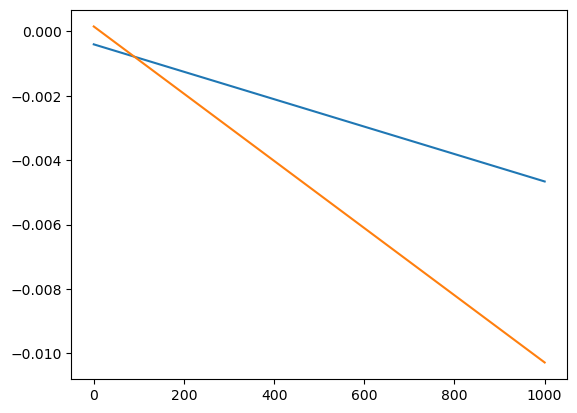

In [44]:
mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq','r99p9','r99p9_sq']
mod_str = 'growth~'+'+'.join(mod_vars)+'+'+'+'.join([f'{v}_lag1' for v in mod_vars])+"|county+year"
mod_r99p9 = pf.feols(mod_str,data=mod_mat)

import matplotlib.pyplot as plt
ps = np.arange(1001)
me0 = mod_r99p9.coef()['r99p9']+2*ps*mod_r99p9.coef()['r99p9_sq']
me1 = mod_r99p9.coef()['r99p9_lag1']+2*ps*mod_r99p9.coef()['r99p9_sq_lag1']
plt.plot(ps,me0)
plt.plot(ps,me0+me1)

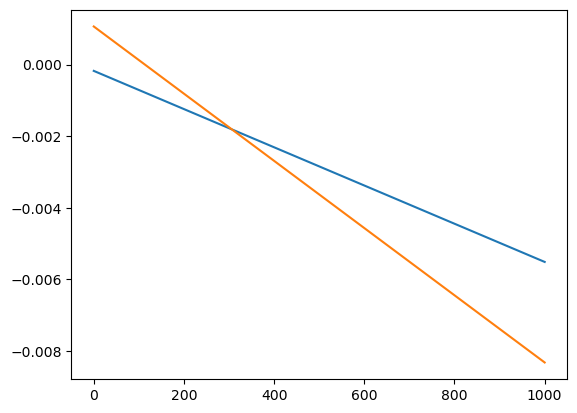

In [251]:
mod_mat['gdp_mean'] = mod_mat.groupby("county")['gdp'].transform(lambda x: x.mean())
mod_mat['gdp_cat'] = pd.cut(mod_mat['gdp_mean'],
                            mod_mat['gdp_mean'].quantile([0,1/3,2/3,1]),
                            labels=['low','mid','high'])

In [32]:
mod_vars = ['ppt_ann','ppt_ann_sq','tmean','tmean_sq']
mod_str = 'growth~'+'+'.join(mod_vars)+'+'+'+'.join([f'{v}_lag1' for v in mod_vars])
mod_str = mod_str+'+(p_exc_rxmon+p_exc_rxmon_sq+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)*C(metro)|county+year'

In [33]:
mod_urb = pf.feols(mod_str,data=mod_mat)

In [37]:
coef

Coefficient
ppt_ann                                2.391768e-04
ppt_ann_sq                            -2.604118e-08
tmean                                 -3.326771e-01
tmean_sq                               2.446476e-02
ppt_ann_lag1                          -5.809056e-03
ppt_ann_sq_lag1                        1.987520e-06
tmean_lag1                            -4.090127e-01
tmean_sq_lag1                          2.968444e-02
p_exc_rxmon                            2.929730e-03
p_exc_rxmon_sq                        -1.846473e-05
p_exc_rxmon_lag1                      -2.716012e-03
p_exc_rxmon_sq_lag1                    1.353979e-05
p_exc_rxmon:C(metro)[T.1.0]           -2.346249e-03
p_exc_rxmon_sq:C(metro)[T.1.0]         1.306385e-05
p_exc_rxmon_lag1:C(metro)[T.1.0]       5.359118e-03
p_exc_rxmon_sq_lag1:C(metro)[T.1.0]   -1.153167e-05
Name: Estimate, dtype: float64

In [28]:
hyde.sort_values("urban_area_frac")

,county,urban_area_frac
2734,48279,0.000000
2835,48105,0.000000
2834,48461,0.000000
2833,48103,0.000000
2832,48269,0.000000
...,...,...
223,42101,0.993829
311,36047,0.993841
202,11001,0.999984
234,34039,0.999984


In [162]:
mod_tx5d = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+tmean*tx5d|county+year",data=mod_mat)
mod_tx5d.coef()['tx5d']/-mod_tx5d.coef()['tmean:tx5d']

np.float64(7.298559015432047)

In [157]:
mod = pf.feols(mod_str,vcov={"CRV1":"year"},data=mod_mat)
mod.summary()

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  61560

| Coefficient         |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ppt_ann             |      0.000 |        0.003 |     0.146 |      0.885 | -0.005 |   0.006 |
| ppt_ann_sq          |     -0.000 |        0.000 |    -0.093 |      0.927 | -0.000 |   0.000 |
| tmean               |     -0.391 |        0.629 |    -0.621 |      0.542 | -1.706 |   0.925 |
| tmean_sq            |      0.026 |        0.023 |     1.150 |      0.264 | -0.022 |   0.075 |
| p_exc_rxmon         |      0.002 |        0.002 |     1.267 |      0.221 | -0.001 |   0.005 |
| p_exc_rxmon_sq      |     -0.000 |        0.000 |    -3.270 |      0.004 | -0.000 |  -0.000 |
| ppt_ann_lag1        |     -0.006 |        0.003 |    -2.052 |      0.054 | -0.012 |   0.000 |
| ppt_ann_sq_lag1     |      

In [147]:
mod_sep = pf.feols("growth~ppt_ann+ppt_ann_sq+ppt_ann_lag1+ppt_ann_sq_lag1+tmean+tmean_sq+tmean_lag1+tmean_sq_lag1+rxmon_pexcmax*tws_def_pre_pexcmax+rxmon_pexcmax_sq+rxmon_pexcmax_lag1*tws_def_pre_pexcmax_lag1+rxmon_pexcmax_sq_lag1|county+year",data=mod_mat)


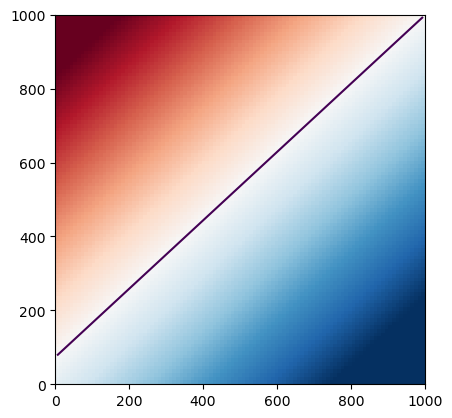

In [152]:
sep_coef = mod_sep.coef()
ps = np.arange(0,1001,10)
ts = np.arange(0,1001,10)
me0 = np.empty((len(ps),len(ts)))
for i,p in enumerate(ps):
    for j,t in enumerate(ts):
        me0[i,j] = sep_coef['rxmon_pexcmax']+2*p*sep_coef['rxmon_pexcmax_sq']+t*sep_coef['rxmon_pexcmax:tws_def_pre_pexcmax']
fig,ax=plt.subplots()
ax.imshow(me0,origin='lower',extent=[0,1000,0,1000],cmap='RdBu',vmin=-0.02,vmax=0.02)
ax.contour(me0,[0],origin='lower',extent=[0,1000,0,1000],color='black')

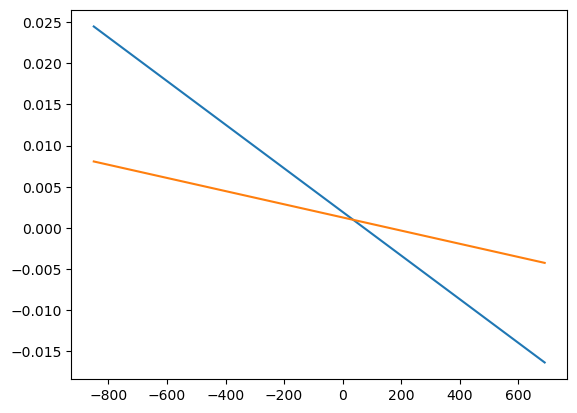

In [141]:
mod = pf.feols(mod_str,data=mod_mat)
coef = mod.coef()
fp = np.linspace(mod_mat['p_exc_rxmon'].min(),mod_mat['p_exc_rxmon'].max(),1000)
me0 = coef['p_exc_rxmon']+2*fp*coef['p_exc_rxmon_sq']
me1 = coef['p_exc_rxmon_lag1']+2*fp*coef['p_exc_rxmon_sq_lag1']
plt.plot(fp,me0)
plt.plot(fp,me0+me1)

In [142]:
coef['p_exc_rxmon']/2/-coef['p_exc_rxmon_sq']

np.float64(72.91385916351115)

In [71]:
mod_reg = pf.feols("growth~(ppt_ann+ppt_ann_lag1+ppt_ann_sq+ppt_ann_sq_lag1+tmean+tmean_lag1+tmean_sq_lag1+p_exc_rxmon+p_exc_rxmon_lag1+p_exc_rxmon_sq+p_exc_rxmon_sq_lag1)*C(region)|county+year",data=mod_mat)

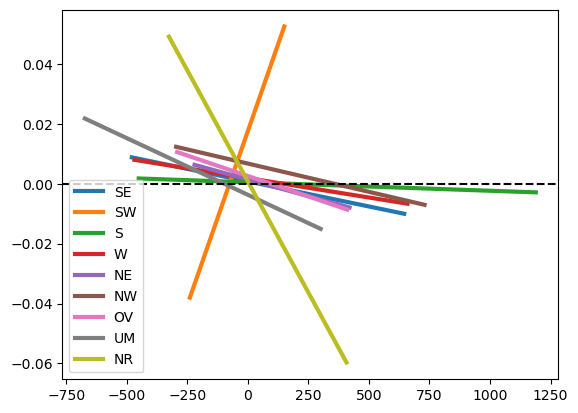

In [72]:
import matplotlib.pyplot as plt
reg_coef = mod_reg.coef()
fig,ax=plt.subplots()
for r in mod_mat['region'].unique():
    fp = np.linspace(mod_mat[mod_mat.region==r]['p_exc_rxmon'].min(),mod_mat[mod_mat.region==r]['p_exc_rxmon'].max(),1000)
    if r=='NE':
        me = reg_coef['p_exc_rxmon']+2*fp*reg_coef['p_exc_rxmon_sq']
    else:
        me = reg_coef['p_exc_rxmon']+2*fp*reg_coef['p_exc_rxmon_sq']+ reg_coef[f'p_exc_rxmon:C(region)[T.{r}]']+2*fp*reg_coef[f'p_exc_rxmon_sq:C(region)[T.{r}]']
    ax.plot(fp,me,lw=3,label=r)
ax.axhline(0,color='black',linestyle='--')
ax.legend()


In [75]:
r

'DC'

mod_gdp = pf.feols("growth~ppt_ann+ppt_ann_lag1+ppt_ann_sq+ppt_ann_sq_lag1+tmean+tmean_lag1+tmean_sq_lag1+(p_exc_rxmon+p_exc_rxmon_lag1+p_exc_rxmon_sq+p_exc_rxmon_sq_lag1)*C(gdp_cat)|county+year",data=mod_mat)

In [257]:
gdp_coef

Coefficient
ppt_ann                                  -1.110676e-03
ppt_ann_lag1                             -3.492577e-03
ppt_ann_sq                                4.749126e-07
ppt_ann_sq_lag1                           1.228088e-06
tmean                                     1.208189e-01
tmean_lag1                               -4.388260e-01
tmean_sq_lag1                             3.665264e-02
p_exc_rxmon                               4.303205e-03
p_exc_rxmon_lag1                         -1.874701e-03
p_exc_rxmon_sq                           -2.262797e-05
p_exc_rxmon_sq_lag1                       2.683565e-05
p_exc_rxmon:C(gdp_cat)[T.mid]            -1.635575e-03
p_exc_rxmon:C(gdp_cat)[T.high]           -4.720435e-03
p_exc_rxmon_lag1:C(gdp_cat)[T.mid]        9.266201e-05
p_exc_rxmon_lag1:C(gdp_cat)[T.high]       3.340758e-03
p_exc_rxmon_sq:C(gdp_cat)[T.mid]          1.235939e-05
p_exc_rxmon_sq:C(gdp_cat)[T.high]         2.011984e-05
p_exc_rxmon_sq_lag1:C(gdp_cat)[T.mid]    -1.836212e-0

In [270]:
mod_mat[mod_mat['flood_decl_incltc']==1].groupby("gdp_cat")['p_exc_rxmon'].mean()

gdp_cat
low     79.867508
mid     83.112220
high    71.763336
Name: p_exc_rxmon, dtype: float64

In [267]:
mod_mat[(mod_mat['p_exc_rxmon']>200)].groupby("gdp_cat")['flood_decl_incltc'].mean()

gdp_cat
low     0.532742
mid     0.469663
high    0.459239
Name: flood_decl_incltc, dtype: float64

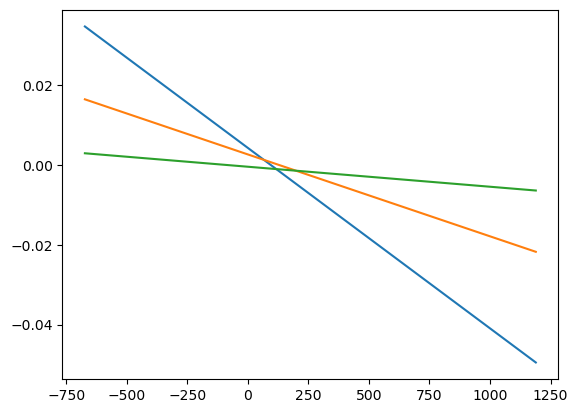

In [259]:
gdp_coef = mod_gdp.coef()
me_low = gdp_coef['p_exc_rxmon']+gdp_coef['p_exc_rxmon_sq']*2*fp
me_mid = me_low+gdp_coef['p_exc_rxmon:C(gdp_cat)[T.mid]']+gdp_coef['p_exc_rxmon_sq:C(gdp_cat)[T.mid]']*2*fp
me_high = me_low+gdp_coef['p_exc_rxmon:C(gdp_cat)[T.high]']+gdp_coef['p_exc_rxmon_sq:C(gdp_cat)[T.high]']*2*fp
plt.plot(fp,me_low)
plt.plot(fp,me_mid)
plt.plot(fp,me_high)

In [203]:
mod_lag1 = pf.feols(mod_str,data=mod_mat)
mod_lag1.summary()

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  61560

| Coefficient         |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ppt_ann             |     -0.000 |        0.001 |    -0.467 |      0.641 | -0.002 |   0.001 |
| ppt_ann_sq          |      0.000 |        0.000 |     0.535 |      0.593 | -0.000 |   0.000 |
| tmean               |     -0.424 |        0.170 |    -2.496 |      0.013 | -0.756 |  -0.091 |
| tmean_sq            |      0.028 |        0.007 |     4.027 |      0.000 |  0.014 |   0.041 |
| p_exc_rxmon         |      0.002 |        0.001 |     3.710 |      0.000 |  0.001 |   0.004 |
| p_exc_rxmon_sq      |     -0.000 |        0.000 |    -6.733 |      0.000 | -0.000 |  -0.000 |
| ppt_ann_lag1        |     -0.003 |        0.001 |    -4.088 |      0.000 | -0.005 |  -0.002 |
| ppt_ann_sq_lag1     |      

In [205]:
mod_lag1.vcov({"CRV1":"state"}).summary()

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  61560

| Coefficient         |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ppt_ann             |     -0.000 |        0.002 |    -0.194 |      0.847 | -0.004 |   0.003 |
| ppt_ann_sq          |      0.000 |        0.000 |     0.244 |      0.808 | -0.000 |   0.000 |
| tmean               |     -0.424 |        0.435 |    -0.974 |      0.335 | -1.298 |   0.450 |
| tmean_sq            |      0.028 |        0.016 |     1.715 |      0.093 | -0.005 |   0.060 |
| p_exc_rxmon         |      0.002 |        0.001 |     1.654 |      0.105 | -0.001 |   0.005 |
| p_exc_rxmon_sq      |     -0.000 |        0.000 |    -2.818 |      0.007 | -0.000 |  -0.000 |
| ppt_ann_lag1        |     -0.003 |        0.002 |    -1.639 |      0.108 | -0.007 |   0.001 |
| ppt_ann_sq_lag1     |      

In [207]:
me0=mod_lag1.coef()['p_exc_rxmon']+2*fp*mod_lag1.coef()['p_exc_rxmon_sq']
me1=mod_lag1.coef()['p_exc_rxmon_lag1']+2*fp*mod_lag1.coef()['p_exc_rxmon_sq_lag1']

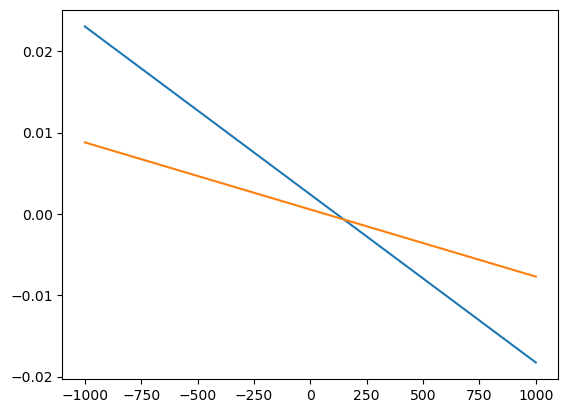

In [209]:
plt.plot(fp,me0)
plt.plot(fp,me0+me1)

In [94]:
import geopandas as gpd
dams = gpd.read_file(os.path.join(root_dir,'Data','Other','GlobalDamWatch'))
counties = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))

In [95]:
dams = dams[dams.COUNTRY=='United States']
dams_rp = dams.copy()
dams_rp['geometry'] = dams['geometry'].representative_point()
dams_rp['fcon_dam'] = dams_rp['USE_FCON'].notnull()


In [96]:
dams_sjoin = dams_rp[['fcon_dam','geometry']].sjoin(counties[['county','geometry']])
county_dams = dams_sjoin.groupby("county",as_index=False)['fcon_dam'].max()

In [97]:
nld = gpd.read_file(os.path.join(project_dir,'data','raw','natl_levee_db','leveed_areas.geojson'))
nld_rp = nld.copy()
nld_rp['geometry'] = nld_rp['geometry'].representative_point()

In [98]:
nld_rp['levee'] = True

In [99]:
nld_sjoin = nld_rp[['levee','geometry']].sjoin(counties[['county','geometry']])
county_levees = nld_sjoin.groupby("county",as_index=False)['levee'].max()

In [100]:
mod_mat = mod_mat.merge(county_levees,on='county',how='left').merge(county_dams,on='county',how='left')


In [101]:
mod_mat['levee'].fillna(False,inplace=True)
mod_mat['fcon_dam'].fillna(False,inplace=True)


In [102]:
mod_mat['levee'].mean()

np.float64(0.33214285714285713)

In [103]:
mod_mat['dam_levee'] = mod_mat['levee']|mod_mat['fcon_dam']


<Axes: >

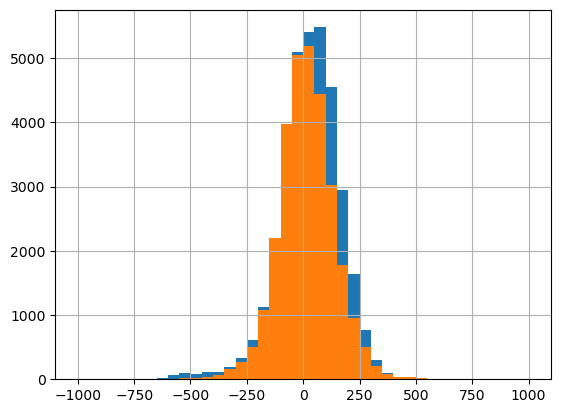

In [107]:
mod_mat[mod_mat['dam_levee']==0]['p_exc_rxmon'].hist(bins=np.arange(-1000,1001,50))
mod_mat[mod_mat['dam_levee']==1]['p_exc_rxmon'].hist(bins=np.arange(-1000,1001,50))

In [76]:
mod_mat_clip = mod_mat.copy()
mod_mat_clip['p_exc_rxmon'] = mod_mat_clip['p_exc_rxmon'].clip(lower=0)
mod_mat_clip['p_exc_rxmon_sq'] = mod_mat_clip['p_exc_rxmon_sq'].clip(lower=0)
mod_mat_clip['p_exc_rxmon_lag1'] = mod_mat_clip['p_exc_rxmon_lag1'].clip(lower=0)
mod_mat_clip['p_exc_rxmon_sq_lag1'] = mod_mat_clip['p_exc_rxmon_sq_lag1'].clip(lower=0)

<Axes: >

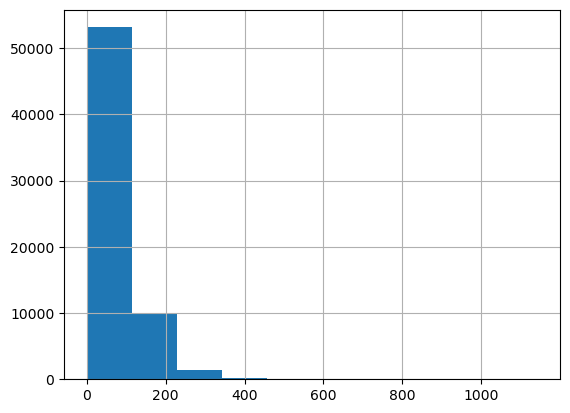

In [81]:
mod_mat_clip['p_exc_rxmon'].hist()

In [77]:
mod_clip = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",data=mod_mat_clip)


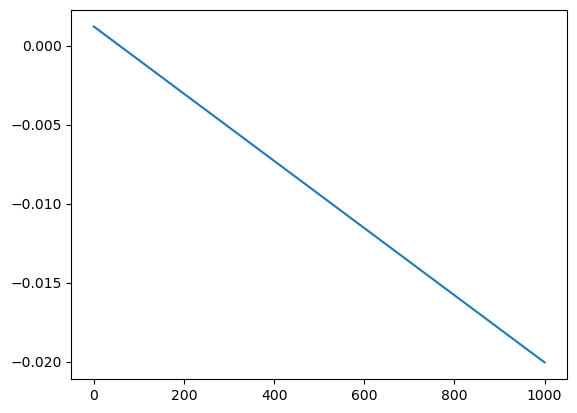

In [79]:
plt.plot(np.arange(1001),mod_clip.coef()['p_exc_rxmon']+2*np.arange(1001)*mod_clip.coef()['p_exc_rxmon_sq'])

In [230]:
mod_fcon = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+ppt_ann_lag1+ppt_ann_sq_lag1+tmean_lag1+tmean_sq_lag1+(p_exc_rxmon+p_exc_rxmon_sq+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)*C(dam_levee)|county + year",data=mod_mat)


In [ ]:
mod_fcon.summary()


In [67]:
mod_fcon = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)+i(county,t)|county + year",data=mod_mat[mod_mat['fcon_dam']])
mod_nofcon = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)+i(county,t)|county + year",data=mod_mat[~mod_mat['fcon_dam']])


In [232]:
fcon_bs = []
counties = mod_mat['county'].unique()
n_counties = len(counties)

for b in range(1000):
    county_samp = np.random.choice(counties,n_counties)
    samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+ppt_ann_lag1+ppt_ann_sq_lag1+tmean_lag1+tmean_sq_lag1+(p_exc_rxmon+p_exc_rxmon_sq+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)*C(dam_levee)|county + year",data=samp_mat)
    fcon_bs.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
fcon_bs = pd.concat(fcon_bs,axis=1)
fcon_bs.columns=np.arange(1000)+1
fcon_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se','fcon.csv'))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


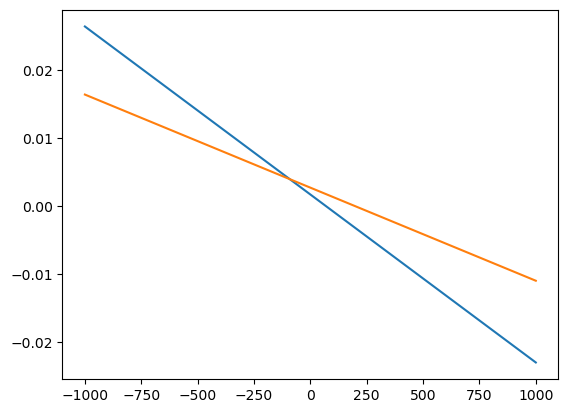

In [87]:
fp = np.arange(-1000,1001)
me_nodec = mod.coef()['p_exc_rxmon']+2*fp*mod.coef()['p_exc_rxmon_sq']
me_dec = me_nodec + mod.coef()['p_exc_rxmon:C(flood_decl_incltc)[T.1.0]']+2*fp*mod.coef()['p_exc_rxmon_sq:C(flood_decl_incltc)[T.1.0]']
plt.plot(fp,me_nodec)
plt.plot(fp,me_dec)



In [117]:
mod_mat.columns


Index(['Unnamed: 0', 'county', 'year', 'GeoName', 'gdp', 'pop', 'gdppc',
       'growth', 'growth_lag1', 'High_Farming_2025', 'High_Government_2025',
       'High_Manufacturing_2025', 'High_Mining_2025', 'High_Recreation_2025',
       'Housing_Stress_2025', 'Industry_Dependence_2025',
       'Low_Employment_2025', 'Low_PostSecondary_Ed_2025',
       'Nonspecialized_2025', 'Persistent_Poverty_1721',
       'Population_Loss_2025', 'Retirement_Destination_2025', 'metro',
       'flood_decl_notc', 'flood_decl_incltc', 'flood_decl_notc_lag1',
       'flood_decl_incltc_lag1', 'ppt_ann', 'p_exc_rxmon', 'band_x',
       'spatial_ref_x', 'p_exc_rxmon_sq', 'ppt_ann_sq', 'p_exc_rxmon_lag0',
       'p_exc_rxmon_lag1', 'p_exc_rxmon_lag2', 'p_exc_rxmon_lag3',
       'p_exc_rxmon_sq_lag0', 'p_exc_rxmon_sq_lag1', 'p_exc_rxmon_sq_lag2',
       'p_exc_rxmon_sq_lag3', 'ppt_ann_lag0', 'ppt_ann_lag1', 'ppt_ann_lag2',
       'ppt_ann_lag3', 'ppt_ann_sq_lag0', 'ppt_ann_sq_lag1', 'ppt_ann_sq_lag2',
       'pp

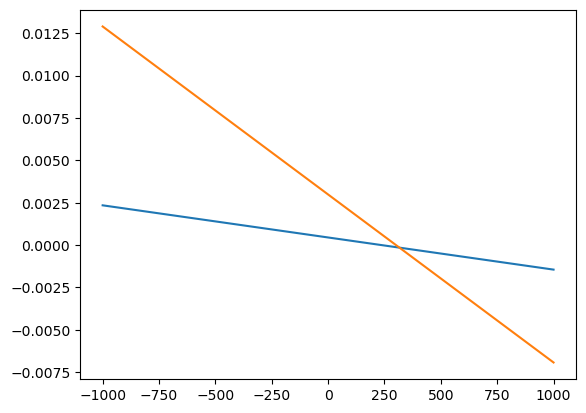

In [126]:
mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+ppt_ann_lag1+ppt_ann_sq_lag1+tmean_lag1+tmean_sq_lag1+(p_exc_rxmon+p_exc_rxmon_sq)*C(flood_decl_incltc)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)*C(flood_decl_incltc_lag1)|county + year",data=mod_mat)
coef = mod.coef()
me0_nodec = coef['p_exc_rxmon']+2*fp*coef['p_exc_rxmon_sq']
me1_nodec = me0_nodec+coef['p_exc_rxmon_lag1']+2*fp*coef['p_exc_rxmon_sq_lag1']

me0_dec = me0_nodec+coef['p_exc_rxmon:C(flood_decl_incltc)[T.1.0]']+2*fp*coef['p_exc_rxmon_sq:C(flood_decl_incltc)[T.1.0]']
me1_dec = me1_nodec+coef['p_exc_rxmon:C(flood_decl_incltc)[T.1.0]']+2*fp*coef['p_exc_rxmon_sq:C(flood_decl_incltc)[T.1.0]']+coef['p_exc_rxmon_lag1:C(flood_decl_incltc_lag1)[T.1.0]']+2*fp*coef['p_exc_rxmon_sq_lag1:C(flood_decl_incltc_lag1)[T.1.0]']

plt.plot(fp,me1_nodec)
plt.plot(fp,me1_dec)

In [127]:
fema_bs = []
counties = mod_mat['county'].unique()
n_counties = len(counties)

for b in range(1000):
    county_samp = np.random.choice(counties,n_counties)
    samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+ppt_ann_lag1+ppt_ann_sq_lag1+tmean_lag1+tmean_sq_lag1+(p_exc_rxmon+p_exc_rxmon_sq)*C(flood_decl_incltc)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)*C(flood_decl_incltc_lag1)|county + year",data=samp_mat)
    fema_bs.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
fema_bs = pd.concat(fema_bs,axis=1)
fema_bs.columns=np.arange(1000)+1
fema_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se','fema.csv'))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [246]:
fp = np.linspace(mod_mat['p_exc_rxmon'].min(),mod_mat['p_exc_rxmon'].max(),1000)
me_nofcon = fcon_bs.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(fcon_bs.loc['p_exc_rxmon_sq'],fp)
me_fcon = me_nofcon + fcon_bs.loc['p_exc_rxmon:C(dam_levee)[T.True]'].values.reshape(-1,1)+2*np.outer(fcon_bs.loc['p_exc_rxmon_sq:C(dam_levee)[T.True]'],fp)

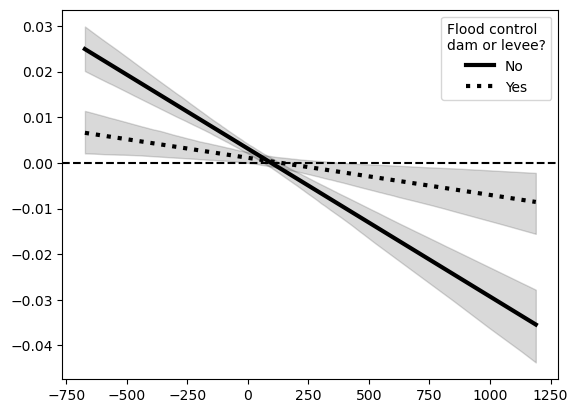

In [247]:
fig,ax=plt.subplots()
ax.plot(fp,me_nofcon.mean(axis=0),color='black',lw=3,label='No')
ax.fill_between(fp,np.quantile(me_nofcon,0.025,axis=0),np.quantile(me_nofcon,0.975,axis=0),color='black',alpha=0.15)
ax.plot(fp,me_fcon.mean(axis=0),color='black',lw=3,linestyle=':',label='Yes')
ax.fill_between(fp,np.quantile(me_fcon,0.025,axis=0),np.quantile(me_fcon,0.975,axis=0),color='black',alpha=0.15)
ax.axhline(0,color='black',linestyle='--')
ax.legend(loc='upper right',title='Flood control\ndam or levee?')

In [128]:
me0_nofema = fema_bs.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(fema_bs.loc['p_exc_rxmon_sq'],fp)
me0_fema = me_nofema + fema_bs.loc['p_exc_rxmon:C(flood_decl_incltc)[T.1.0]'].values.reshape(-1,1)+2*np.outer(fema_bs.loc['p_exc_rxmon_sq:C(flood_decl_incltc)[T.1.0]'],fp)

In [129]:
me1_nofema = fema_bs.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(fema_bs.loc['p_exc_rxmon_sq_lag1'],fp)
me1_fema = me1_nofema + fema_bs.loc['p_exc_rxmon_lag1:C(flood_decl_incltc_lag1)[T.1.0]'].values.reshape(-1,1)+2*np.outer(fema_bs.loc['p_exc_rxmon_sq_lag1:C(flood_decl_incltc_lag1)[T.1.0]'],fp)

In [133]:
me1_nofema = me0_nofema+me1_nofema
me1_fema = me0_fema+me1_fema

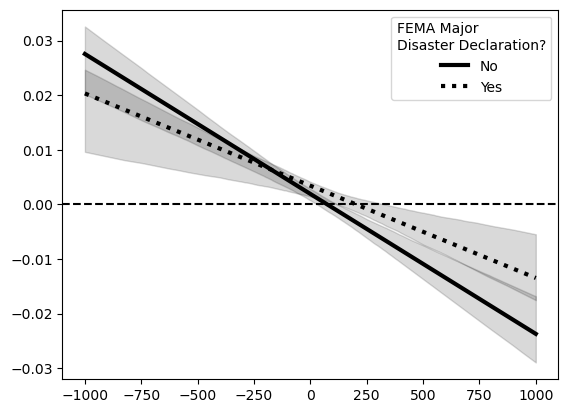

In [130]:
fig,ax=plt.subplots()
ax.plot(fp,me0_nofema.mean(axis=0),color='black',lw=3,label='No')
ax.fill_between(fp,np.quantile(me_nofema,0.025,axis=0),np.quantile(me_nofema,0.975,axis=0),color='black',alpha=0.15)
ax.plot(fp,me0_fema.mean(axis=0),color='black',lw=3,linestyle=':',label='Yes')
ax.fill_between(fp,np.quantile(me_fema,0.025,axis=0),np.quantile(me_fema,0.975,axis=0),color='black',alpha=0.15)
ax.axhline(0,color='black',linestyle='--')
ax.legend(loc='upper right',title='FEMA Major\nDisaster Declaration?')

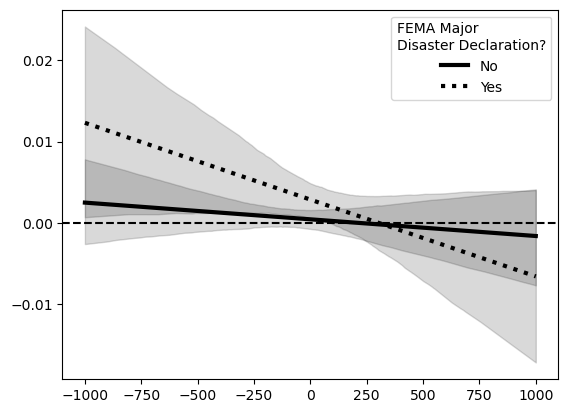

In [134]:
fig,ax=plt.subplots()
ax.plot(fp,me1_nofema.mean(axis=0),color='black',lw=3,label='No')
ax.fill_between(fp,np.quantile(me1_nofema,0.025,axis=0),np.quantile(me1_nofema,0.975,axis=0),color='black',alpha=0.15)
ax.plot(fp,me1_fema.mean(axis=0),color='black',lw=3,linestyle=':',label='Yes')
ax.fill_between(fp,np.quantile(me1_fema,0.025,axis=0),np.quantile(me1_fema,0.975,axis=0),color='black',alpha=0.15)
ax.axhline(0,color='black',linestyle='--')
ax.legend(loc='upper right',title='FEMA Major\nDisaster Declaration?')

Text(0, 0.5, 'Marginal effect (p.p. per mm)')

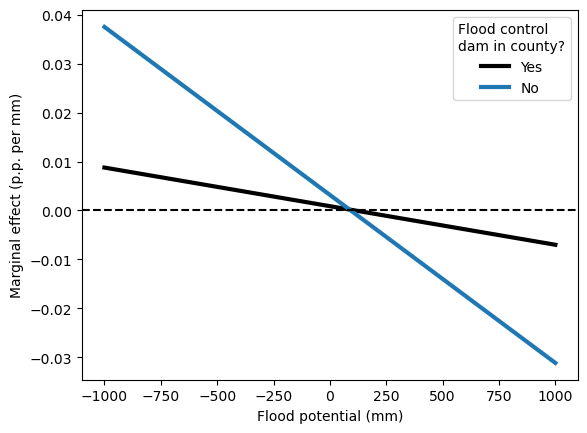

In [182]:
fig,ax=plt.subplots()
ax.plot(fp,fcon_coef['p_exc_rxmon']+2*fp*fcon_coef['p_exc_rxmon_sq']+fcon_coef['p_exc_rxmon:C(dam_levee)[T.True]']+2*fp*fcon_coef['p_exc_rxmon_sq:C(dam_levee)[T.True]'],color='black',lw=3,label='Yes')
ax.plot(fp,fcon_coef['p_exc_rxmon']+2*fp*fcon_coef['p_exc_rxmon_sq'],color='tab:blue',lw=3,label='No')
ax.axhline(0,color='black',linestyle='--')
ax.legend(title='Flood control\ndam in county?')
ax.set_xlabel("Flood potential (mm)")
ax.set_ylabel("Marginal effect (p.p. per mm)")

<Axes: >

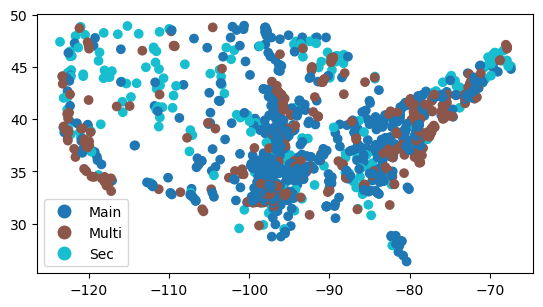

In [43]:
dams_rp.plot(column='USE_FCON',legend=True)

In [26]:
dams['MAIN_USE'].value_counts()


MAIN_USE
Irrigation           2026
Hydroelectricity     2005
Water supply         1245
Flood control        1011
Multipurpose          787
Recreation            741
Other                 238
Navigation             62
Pollution control      45
Fisheries              36
Name: count, dtype: int64

In [132]:
mod_mat = pd.read_csv(os.path.join(project_dir,'data','processed','panels','prism-rain_clsm-grace_county_panel.csv'))

91.04407501220703


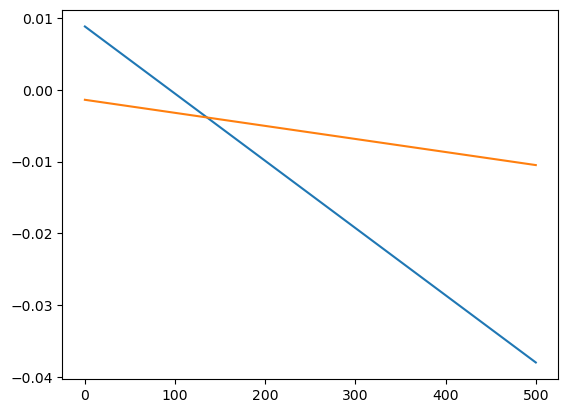

In [18]:
from time import time
t0 = time()
mod_rx1d = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rx1d+np.power(rx1d,2)+rx1d_lag1+(np.power(rx1d_lag1,2))+i(county,t)|county + year",data=mod_mat)
t1 = time()
print(t1-t0)
ps = np.arange(501)
me0 = mod_rx1d.coef()['rx1d']+2*ps*mod_rx1d.coef()['np.power(rx1d, 2)']
me1 = mod_rx1d.coef()['rx1d_lag1']+2*ps*mod_rx1d.coef()['np.power(rx1d_lag1, 2)']
plt.plot(ps,me0)
plt.plot(ps,me0+me1)

In [ ]:
mod_rx1d.vcov({"CRV1":"state"}).summary()

In [186]:
mod_rx5d.summary()


###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  61600

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ppt_ann                |      0.002 |        0.001 |     3.195 |      0.001 |  0.001 |   0.004 |
| ppt_ann_sq             |     -0.000 |        0.000 |    -1.935 |      0.053 | -0.000 |   0.000 |
| tmean                  |     -0.730 |        0.167 |    -4.364 |      0.000 | -1.058 |  -0.402 |
| tmean_sq               |      0.043 |        0.007 |     6.418 |      0.000 |  0.030 |   0.056 |
| rx5d                   |     -0.004 |        0.002 |    -1.966 |      0.049 | -0.009 |  -0.000 |
| np.power(rx5d, 2)      |      0.000 |        0.000 |     0.160 |      0.873 | -0.000 |   0.000 |
| rx5d_lag1              |     -0.001 |        0.002 |    -0.721 |      0.471 | -0.004 |   0.002 |
| 

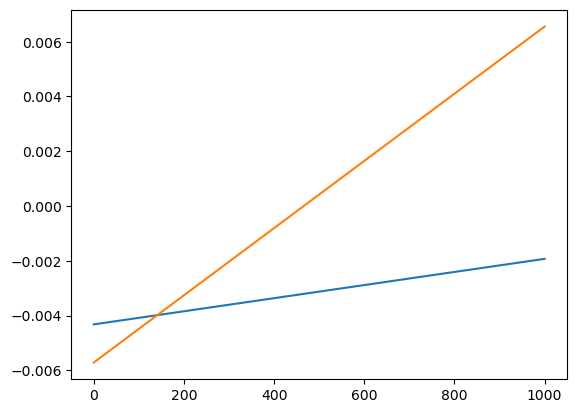

In [16]:
mod_rx5d = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rx5d+np.power(rx5d,2)+rx5d_lag1+(np.power(rx5d_lag1,2))+i(county,t)|county + year",data=mod_mat)
mod_rx5d.coef()['rx5d']/2/-mod_rx5d.coef()['np.power(rx5d, 2)']
ps = np.arange(1001)
me0 = mod_rx5d.coef()['rx5d']+2*ps*mod_rx5d.coef()['np.power(rx5d, 2)']
me1 = mod_rx5d.coef()['rx5d_lag1']+2*ps*mod_rx5d.coef()['np.power(rx5d_lag1, 2)']
plt.plot(ps,me0)
plt.plot(ps,me0+me1)

###

Estimation:  OLS
Dep. var.: growth, Fixed effects: county+year
Inference:  CRV1
Observations:  61600

| Coefficient             |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ppt_ann                 |      0.002 |        0.001 |     2.523 |      0.012 |  0.000 |   0.004 |
| ppt_ann_sq              |     -0.000 |        0.000 |    -1.727 |      0.084 | -0.000 |   0.000 |
| tmean                   |     -0.706 |        0.167 |    -4.223 |      0.000 | -1.034 |  -0.378 |
| tmean_sq                |      0.042 |        0.007 |     6.225 |      0.000 |  0.029 |   0.055 |
| rxmon                   |     -0.001 |        0.002 |    -0.365 |      0.715 | -0.005 |   0.003 |
| np.power(rxmon, 2)      |     -0.000 |        0.000 |    -0.197 |      0.844 | -0.000 |   0.000 |
| rxmon_lag1              |     -0.003 |        0.002 |    -1.566 |      0.117 | -0.006 |   0

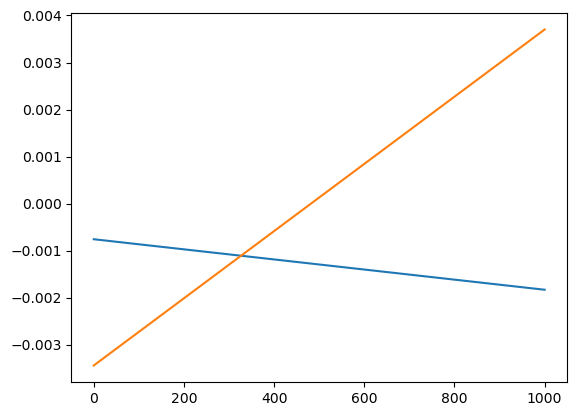

In [17]:
mod_rxmon = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rxmon+np.power(rxmon,2)+rxmon_lag1+(np.power(rxmon_lag1,2))|county + year",data=mod_mat)
mod_rxmon.coef()['rxmon']/2/-mod_rxmon.coef()['np.power(rxmon, 2)']
ps = np.arange(1001)
me0 = mod_rxmon.coef()['rxmon']+2*ps*mod_rxmon.coef()['np.power(rxmon, 2)']
me1 = mod_rxmon.coef()['rxmon_lag1']+2*ps*mod_rxmon.coef()['np.power(rxmon_lag1, 2)']
plt.plot(ps,me0)
plt.plot(ps,me0+me1)
mod_rxmon.summary()

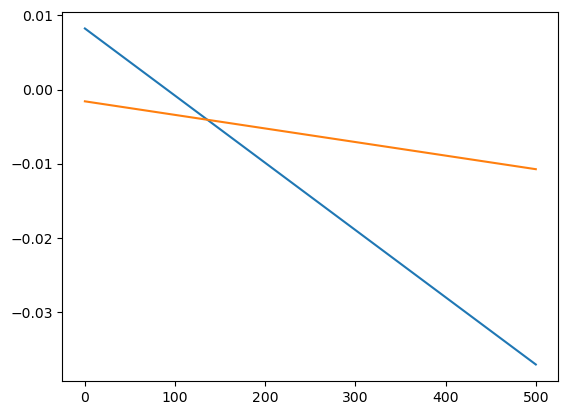

In [114]:
import pyfixest as pf
# mod_cub_lag1 = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq+p_exc_rxmon_cub)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1+p_exc_rxmon_cub_lag1)|county + year",data=mod_mat)
mod_lag1 = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+i(county,t)|county + year",data=mod_mat)
mod_lag1_notr = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",data=mod_mat)


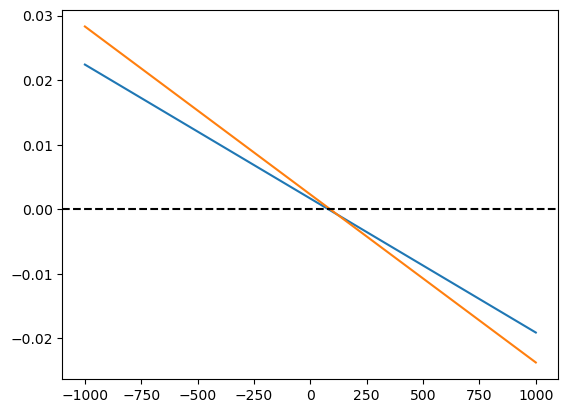

In [115]:
coef_tr = mod_lag1.coef()
coef_notr = mod_lag1_notr.coef()
fig,ax=plt.subplots()
ax.plot(fp,coef_tr['p_exc_rxmon']+2*fp*coef_tr['p_exc_rxmon_sq'])
ax.plot(fp,coef_notr['p_exc_rxmon']+2*fp*coef_notr['p_exc_rxmon_sq'])
ax.axhline(0,color='black',linestyle='--')

Coefficient
ppt_ann                2.735504e-04
ppt_ann_sq            -7.758052e-08
tmean                 -5.083595e-01
tmean_sq               3.296702e-02
p_exc_rxmon            2.804669e-03
p_exc_rxmon_sq        -9.748581e-06
p_exc_rxmon_lag1      -1.940453e-03
p_exc_rxmon_sq_lag1    8.824215e-06
Name: Estimate, dtype: float64

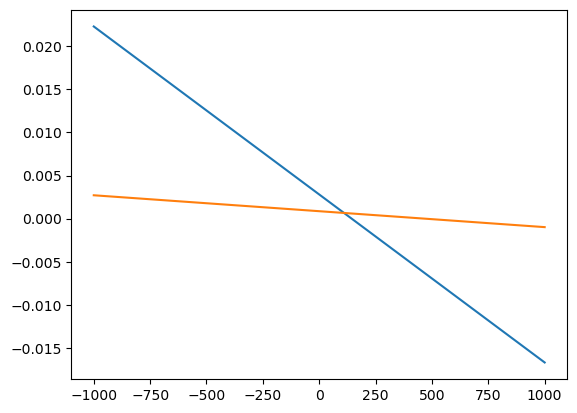

In [9]:
fp = np.arange(-1000,1001,10)
me0 =mod_lag1.coef()['p_exc_rxmon']+2*fp*mod_lag1.coef()['p_exc_rxmon_sq']
me1 =mod_lag1.coef()['p_exc_rxmon_lag1']+2*fp*mod_lag1.coef()['p_exc_rxmon_sq_lag1'] 

import matplotlib.pyplot as plt
plt.plot(fp,me0)
plt.plot(fp,me0+me1)

In [11]:
mod_mat.columns

Index(['Unnamed: 0', 'county', 'year', 'GeoName', 'gdp', 'pop', 'gdppc',
       'growth', 'growth_lag1', 'High_Farming_2025', 'High_Government_2025',
       'High_Manufacturing_2025', 'High_Mining_2025', 'High_Recreation_2025',
       'Housing_Stress_2025', 'Industry_Dependence_2025',
       'Low_Employment_2025', 'Low_PostSecondary_Ed_2025',
       'Nonspecialized_2025', 'Persistent_Poverty_1721',
       'Population_Loss_2025', 'Retirement_Destination_2025', 'metro',
       'flood_decl_notc', 'flood_decl_incltc', 'ppt_ann', 'p_exc_rxmon',
       'band_x', 'spatial_ref_x', 'p_exc_rxmon_sq', 'ppt_ann_sq',
       'p_exc_rxmon_lag0', 'p_exc_rxmon_lag1', 'p_exc_rxmon_lag2',
       'p_exc_rxmon_lag3', 'p_exc_rxmon_sq_lag0', 'p_exc_rxmon_sq_lag1',
       'p_exc_rxmon_sq_lag2', 'p_exc_rxmon_sq_lag3', 'band_y', 'spatial_ref_y',
       'disaster_group', 'rxmon_pexcmax', 'tws_def_pre_pexcmax',
       'rxmon_pexcmax_sq', 'rxmon_pexcmax_lag1', 'rxmon_pexcmax_sq_lag1',
       'tws_def_pre_pexcmax_l

In [12]:
import pyfixest as pf
mod_sep_lag1 = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rxmon_pexcmax+rxmon_pexcmax_sq+rxmon_pexcmax*tws_def_pre_pexcmax+rxmon_pexcmax_lag1+rxmon_pexcmax_sq_lag1+rxmon_pexcmax_lag1*tws_def_pre_pexcmax_lag1+i(county,t)|county + year",data=mod_mat)
sep_coef_lag1 = mod_sep_lag1.coef()

rs = np.arange(0,1001,20)
ts = np.arange(0,1001,20)
me0 = np.zeros((len(rs),len(ts)))
me1 = np.zeros((len(rs),len(ts)))

for i,p in enumerate(rs):
    for j,t in enumerate(ts):
        me0[i,j] = sep_coef_lag1['rxmon_pexcmax']+2*p*sep_coef_lag1['rxmon_pexcmax_sq']+t*sep_coef_lag1['rxmon_pexcmax:tws_def_pre_pexcmax']
        me1[i,j] = sep_coef_lag1['rxmon_pexcmax_lag1']+2*p*sep_coef_lag1['rxmon_pexcmax_sq_lag1']+t*sep_coef_lag1['rxmon_pexcmax_lag1:tws_def_pre_pexcmax_lag1']

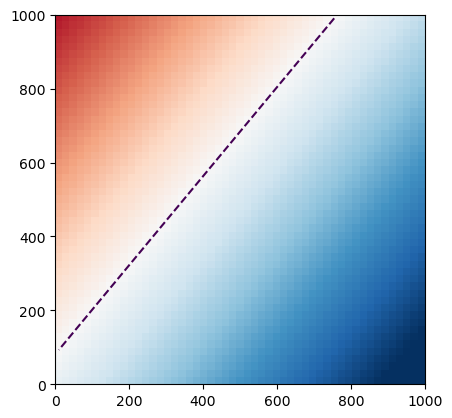

In [13]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.imshow(me0,origin='lower',cmap='RdBu',vmin=-0.02,vmax=0.02,extent=[0,1000,0,1000])
ax.contour(me0,levels=[0],origin='lower',extent=[0,1000,0,1000],color='black',linestyles='--')

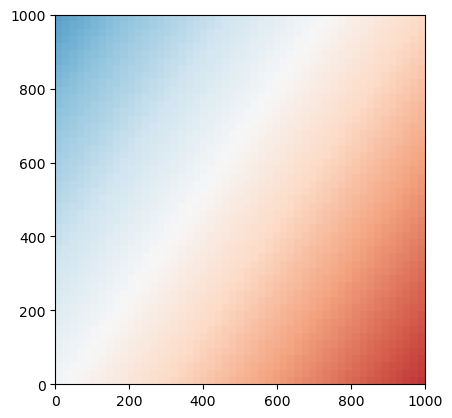

In [36]:
import matplotlib.pyplot as plt
plt.imshow(me0+me1,origin='lower',cmap='RdBu',vmin=-0.02,vmax=0.02,extent=[0,1000,0,1000])

In [37]:
for s in mod_mat['region'].unique():
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",vcov={"CRV1":"state"},data=mod_mat[mod_mat.region!=s])
    print(s,mod.pvalue()['p_exc_rxmon_sq'],mod.coef()['p_exc_rxmon']/-2/mod.coef()['p_exc_rxmon_sq'])

SE 0.4830526609103023 175.82131215518726
SW 0.550411320337346 204.38479953274293
S 0.0356540302101549 92.91193674776883
W 0.5877539991928229 253.00147542547802
NE 0.530099273271615 234.6207836654859
NW 0.5440304505199862 214.9051593867678
OV 0.6488885562378677 253.46229328560503
UM 0.8461682140712816 627.0963948261492
NR 0.7841419328430352 382.1982970856725


In [19]:
# mod_mat = mod_mat[mod_mat.state!='MI']
# mod_mat = mod_mat[mod_mat.state!='TX']
loo_state = {}
for s in mod_mat['state'].unique():
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",vcov={"CRV1":"state"},data=mod_mat[mod_mat.state!=s])
    loo_state[s] = mod.coef()
    print(s,mod.pvalue()['p_exc_rxmon_sq'],mod.coef()['p_exc_rxmon']/-2/mod.coef()['p_exc_rxmon_sq'])

AL 0.00028828514807055505 57.32958218053478
AZ 0.0002653082018544417 55.99757075900538
AR 0.00030302472956722504 53.55099164218342
CA 0.0006855419757068049 56.67413626164488
CO 0.00026107522194673827 52.61963192793981
CT 0.00025594932652284186 57.150917908248104
DE 0.0002526845229224861 56.83650702829953
DC 0.00025009981907198053 56.26059244155741
FL 0.00021367166860764009 50.79566661974442
GA 0.00042779647614121785 58.289911266696386
ID 0.0002409726563015191 59.207540123297825
IL 0.0002782202031972325 49.65770305623989
IN 0.0002802216878430297 57.96586088647102
IA 0.00026248740542711424 55.2858162898303
KS 0.0003571932507109299 80.16165507623857
KY 0.0002375634566564866 52.267028139868586
LA 6.894692218817333e-05 32.79410229489979
ME 0.00025383970863379623 57.782778763488864
MD 0.00025909957958791807 55.59799345056576
MA 0.0002511384449894738 56.52118542960906
MI 0.018767255166413532 67.30474150933945
MN 0.0002970728924314159 72.2124345683338
MS 0.00027473417586842963 56.4958061941582

In [20]:
# mod_mat = mod_mat[mod_mat.state!='MI']
# mod_mat = mod_mat[mod_mat.state!='TX']
loo_year = {}
for s in mod_mat['year'].unique():
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",vcov={"CRV1":"state"},data=mod_mat[mod_mat.year!=s])
    loo_year[s] = mod.coef()
    print(s,mod.pvalue()['p_exc_rxmon_sq'],mod.coef()['p_exc_rxmon']/-2/mod.coef()['p_exc_rxmon_sq'])

2003 0.00024510842441705094 56.270326096128365
2004 0.0023779649768664868 108.61679934091748
2005 0.00027871430880765935 56.7961833003474
2006 1.260331914187951e-05 57.84711473501405
2007 0.00011342548933579444 41.58539995311385
2008 0.0002048669940011294 62.012628338669074
2009 0.0010874493806170005 56.46734435562025
2010 0.00013699145522605427 68.1622937873495
2011 0.0006196487504486203 58.90004441834606
2012 0.0008699256465378724 60.25640574683697
2013 0.0002905195767102242 62.64269647714923
2014 0.00019233532441420564 69.27605050812849
2015 0.00012553422359462552 57.87173956745317
2016 0.0008701429087976109 47.26080033177961
2017 0.0004301861399060858 34.33023836473933
2018 0.0005115420065007203 53.62669281311639
2019 0.0006152374684298412 44.803944545381604
2020 0.00019793497892295342 29.599939374046368
2021 0.0003801136558740925 53.188535622256836
2022 0.00018307548302742838 56.65545247329905
2023 0.0004976772555294051 62.8409401329766


In [21]:
mod_precovid = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",data=mod_mat[mod_mat.year<2020])

In [22]:
mod_mat_flood_wins = mod_mat.copy()
flood_qs = mod_mat.p_exc_rxmon.quantile([0.005,0.995]).values
mod_mat_flood_wins.loc[mod_mat_flood_wins['p_exc_rxmon']>flood_qs[1],'p_exc_rxmon'] = flood_qs[1]
mod_mat_flood_wins.loc[mod_mat_flood_wins['p_exc_rxmon']<flood_qs[0],'p_exc_rxmon'] = flood_qs[0]
mod_mat_flood_wins.loc[mod_mat_flood_wins['p_exc_rxmon_lag1']>flood_qs[1],'p_exc_rxmon_lag1'] = flood_qs[1]
mod_mat_flood_wins.loc[mod_mat_flood_wins['p_exc_rxmon_lag1']<flood_qs[0],'p_exc_rxmon_lag1'] = flood_qs[0]

In [23]:
mod_mat_growth_wins = mod_mat.copy()
growth_qs = mod_mat.growth.quantile([0.005,0.995]).values
mod_mat_growth_wins.loc[mod_mat_growth_wins['growth']>growth_qs[1],'growth'] = growth_qs[1]
mod_mat_growth_wins.loc[mod_mat_growth_wins['growth']<growth_qs[0],'growth'] = growth_qs[0]


In [24]:
mod_mat_both_wins = mod_mat.copy()
mod_mat_both_wins.loc[mod_mat_both_wins['growth']>growth_qs[1],'growth'] = growth_qs[1]
mod_mat_both_wins.loc[mod_mat_both_wins['growth']<growth_qs[0],'growth'] = growth_qs[0]
mod_mat_both_wins.loc[mod_mat_both_wins['p_exc_rxmon']>flood_qs[1],'p_exc_rxmon'] = flood_qs[1]
mod_mat_both_wins.loc[mod_mat_both_wins['p_exc_rxmon']<flood_qs[0],'p_exc_rxmon'] = flood_qs[0]
mod_mat_both_wins.loc[mod_mat_both_wins['p_exc_rxmon_lag1']>flood_qs[1],'p_exc_rxmon_lag1'] = flood_qs[1]
mod_mat_both_wins.loc[mod_mat_both_wins['p_exc_rxmon_lag1']<flood_qs[0],'p_exc_rxmon_lag1'] = flood_qs[0]

In [25]:
mod_growth_wins = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",
                           data=mod_mat_growth_wins)
mod_flood_wins = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",
                          data=mod_mat_flood_wins)
mod_both_wins = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)+(p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)|county + year",
                          data=mod_mat_both_wins)

In [26]:
ps_flood_wins = np.linspace(*mod_mat.p_exc_rxmon.quantile([0.005,0.995]),100)

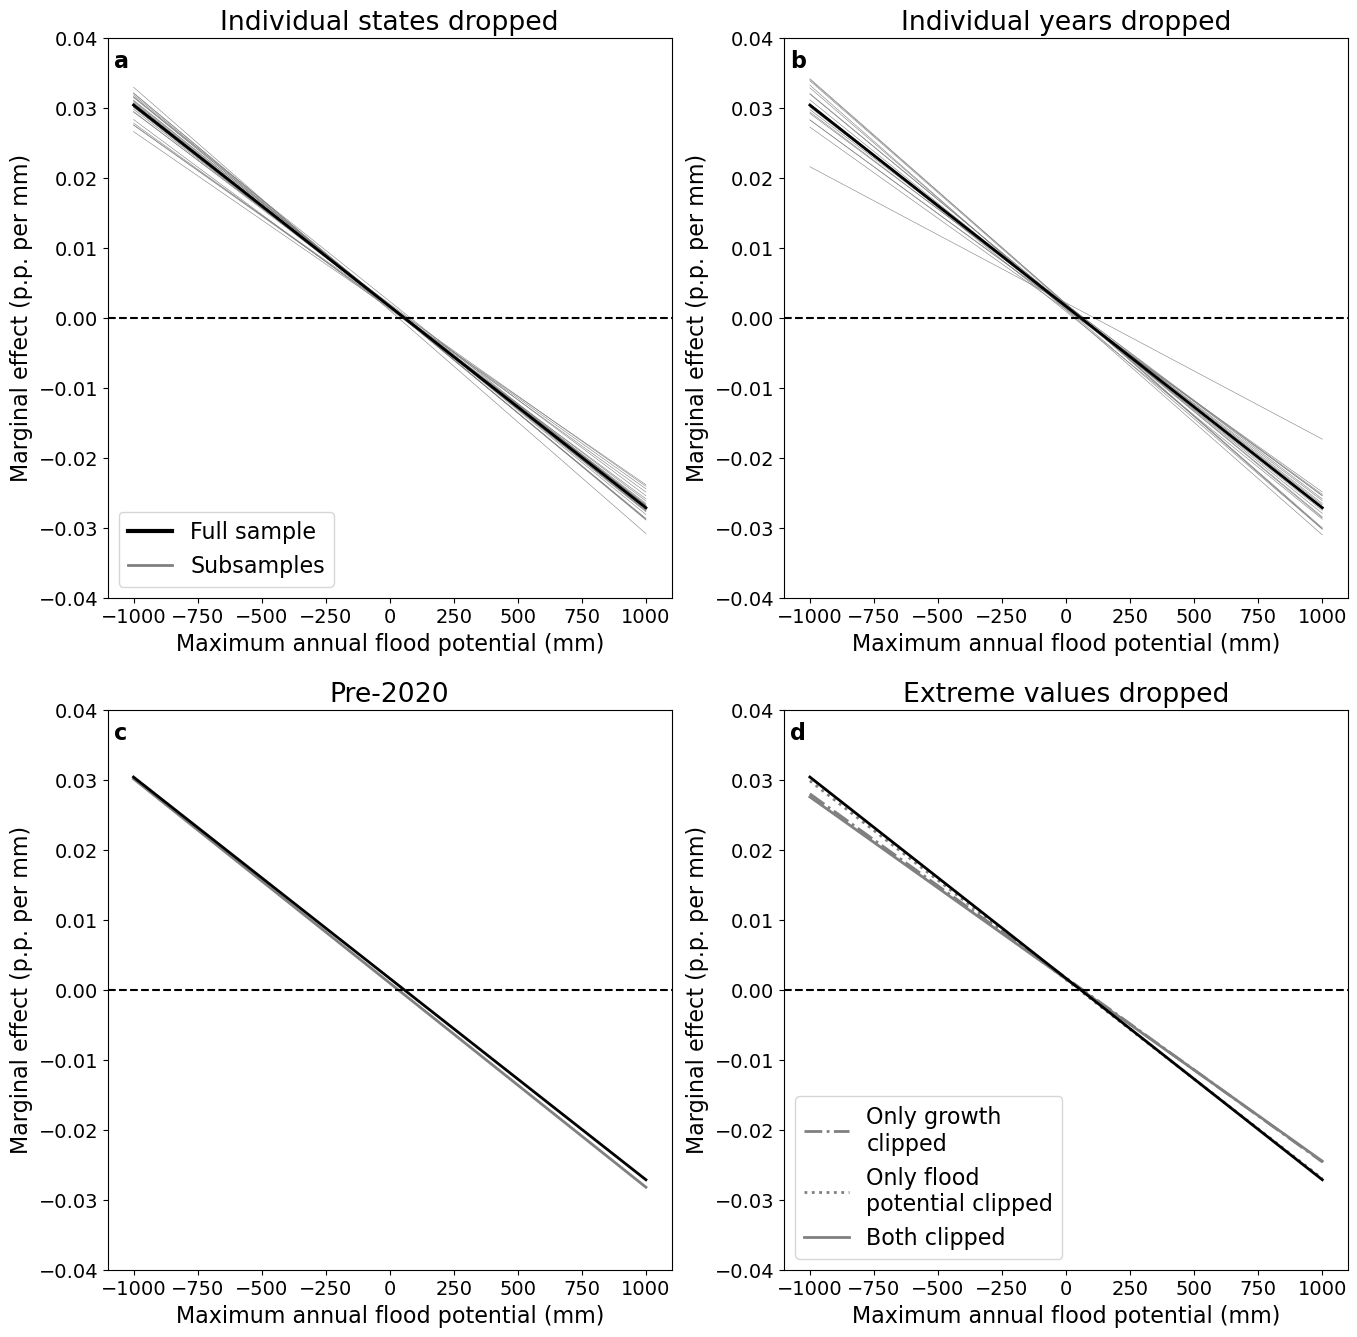

In [35]:
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size

ps = np.arange(-1000,1001)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(nrows=2,ncols=2,figure=fig)
ax1 = plt.subplot(gs[0,0])
for k,v in loo_state.items():
    ax1.plot(ps,v['p_exc_rxmon']+2*ps*v['p_exc_rxmon_sq'],label=s,color='tab:grey',lw=0.4)
ax1.plot(ps,mod_lag1.coef()['p_exc_rxmon']+2*ps*mod_lag1.coef()['p_exc_rxmon_sq'],color='black',lw=2)
ax1.set_ylim(-0.04,0.04)
ax1.title.set_text("Individual states dropped")
leg_el = [Line2D([0], [0], color='black', label='Full sample',lw=3),
          Line2D([0], [0], color='grey', label='Subsamples',lw=2),
         ]
ax1.legend(handles=leg_el,loc='lower left')
ax2 = plt.subplot(gs[0,1],sharey=ax1)
for k,v in loo_year.items():
    ax2.plot(ps,v['p_exc_rxmon']+2*ps*v['p_exc_rxmon_sq'],label=s,color='tab:grey',lw=0.4)
ax2.plot(ps,mod_lag1.coef()['p_exc_rxmon']+2*ps*mod_lag1.coef()['p_exc_rxmon_sq'],color='black',lw=2)
ax2.title.set_text("Individual years dropped")

ax3 = plt.subplot(gs[1,0],sharey=ax1)
ax3.plot(ps,mod_precovid.coef()['p_exc_rxmon']+2*ps*mod_precovid.coef()['p_exc_rxmon_sq'],color='grey',lw=2)
ax3.plot(ps,mod_lag1.coef()['p_exc_rxmon']+2*ps*mod_lag1.coef()['p_exc_rxmon_sq'],color='black',lw=2)
ax3.title.set_text("Pre-2020")

ax4 = plt.subplot(gs[1,1],sharey=ax1)

ax4.plot(ps,mod_growth_wins.coef()['p_exc_rxmon']+2*ps*mod_growth_wins.coef()['p_exc_rxmon_sq'],color='grey',lw=2,linestyle='-.',label='Only growth\nclipped')
ax4.plot(ps,mod_flood_wins.coef()['p_exc_rxmon']+2*ps*mod_flood_wins.coef()['p_exc_rxmon_sq'],color='grey',lw=2,linestyle=':',label='Only flood\npotential clipped')
ax4.plot(ps,mod_both_wins.coef()['p_exc_rxmon']+2*ps*mod_both_wins.coef()['p_exc_rxmon_sq'],color='grey',lw=2,label='Both clipped')
ax4.plot(ps,mod_lag1.coef()['p_exc_rxmon']+2*ps*mod_lag1.coef()['p_exc_rxmon_sq'],color='black',lw=2)
ax4.title.set_text("Extreme values dropped")
ax4.legend(loc='lower left')

for ax in [ax1,ax2,ax3,ax4]:
    ax.axhline(0,color='black',linestyle='--')
    ax.set_ylabel("Marginal effect (p.p. per mm)")
    ax.set_xlabel("Maximum annual flood potential (mm)")
    
labels = ['a','b','c','d']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','robustness.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','supp_mat','robustness.pdf'),bbox_inches='tight',dpi=350)
plt.show()

In [29]:
df = mod_lag1._data
df['resid'] = mod_lag1.resid()
resid = xr.Dataset.from_dataframe(df.set_index(['county','year'])[['resid']])
regions = resid['county'].values
data_2d = resid['resid'].transpose("year", "county").values 
corr_matrix = np.corrcoef(data_2d, rowvar=False)  # shape: (n_regions, n_regions)

# Extract upper triangle without diagonal
i_upper, j_upper = np.triu_indices(len(regions), k=1)
corr_df = pd.DataFrame({
    "region1": regions[i_upper],
    "region2": regions[j_upper],
    "correlation": corr_matrix[i_upper, j_upper]
})

In [30]:
state_dict = dict(zip(mod_mat['county'],mod_mat['state']))
corr_df['state1'] = corr_df['region1'].map(state_dict)
corr_df['state2'] = corr_df['region2'].map(state_dict)

In [31]:
corr_df[corr_df['state1']==corr_df['state2']].groupby("state1")['correlation'].mean()

state1
AL    0.156690
AR    0.108863
AZ    0.210218
CA    0.094057
CO    0.073133
CT    0.286712
DE    0.481604
FL    0.242239
GA    0.074773
IA    0.165317
ID    0.053875
IL    0.086998
IN    0.262316
KS    0.089177
KY    0.055674
LA    0.166157
MA    0.250195
MD    0.248918
ME    0.255530
MI    0.245786
MN    0.088435
MO    0.067079
MS    0.049257
MT    0.015985
NC    0.134993
ND    0.170716
NE    0.117526
NH    0.164851
NJ    0.316438
NM    0.065599
NV    0.228455
NY    0.197515
OH    0.124840
OK    0.092329
OR    0.092384
PA    0.142083
RI    0.108911
SC    0.106068
SD    0.124697
TN    0.140359
TX    0.076194
UT    0.122271
VA    0.034770
VT    0.158790
WA    0.082607
WI    0.112599
WV    0.043017
WY    0.134755
Name: correlation, dtype: float64

0.10389727796176479


<Axes: >

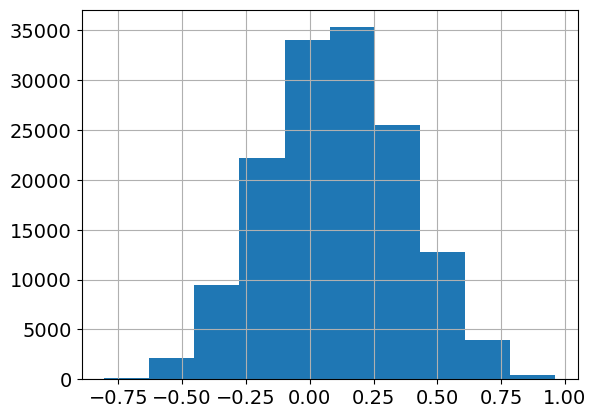

In [34]:
print(corr_df[corr_df['state1']==corr_df['state2']]['correlation'].mean())
corr_df[corr_df['state1']==corr_df['state2']]['correlation'].hist()

In [250]:
base_bs = []
counties = mod_mat['county'].unique()
n_counties = len(counties)

for b in range(1000):
    county_samp = np.random.choice(counties,n_counties)
    samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon+p_exc_rxmon_sq|county + year",data=samp_mat)
    base_bs.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
base_bs = pd.concat(base_bs,axis=1)
base_bs.columns=np.arange(1000)+1
os.makedirs(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se'))
base_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se','base.csv'))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [ ]:
base_bs_state = []
states = mod_mat['state'].unique()
n_states = len(states)

for b in range(1000):
    county_samp = np.random.choice(states,n_states)
    samp_mat = mod_mat[mod_mat.state.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon+p_exc_rxmon_sq|county + year",data=samp_mat)
    base_bs_state.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
base_bs_state = pd.concat(base_bs_state,axis=1)
base_bs_state.columns=np.arange(1000)+1
os.makedirs(os.path.join(project_dir,'data','processed','damage_func_coefs','rain','state_se'))
base_bs_state.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','rain','state_se','base.csv'))

In [253]:
lag1_bs = []
counties = mod_mat['county'].unique()
n_counties = len(counties)

for b in range(1000):
    county_samp = np.random.choice(counties,n_counties)
    samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon_lag0+p_exc_rxmon_sq_lag0+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1|county + year",data=samp_mat)
    lag1_bs.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
lag1_bs = pd.concat(lag1_bs,axis=1)
lag1_bs.columns=np.arange(1000)+1
lag1_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se','lag1.csv'))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [261]:
# lag1_bs = lag1_bs.rename(index={"p_exc_rxmon_sq_lag0":"p_exc_rxmon_sq","p_exc_rxmon_lag0":"p_exc_rxmon"})
lag1_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se','lag1.csv'))

In [ ]:
ps = np.arange(-1000,1001,20)
me0 = lag1_bs.loc['p_exc_rxmon_lag0'].values.reshape(-1,1)+2*np.outer(lag1_bs.loc['p_exc_rxmon_sq_lag0'],ps)
fig,ax=plt.subplots()
ax.plot(ps,me0.mean(axis=0))
ax.fill_between(ps,np.quantile(me0,0.025,axis=0),np.quantile(me0,0.975,axis=0),alpha=0.15)
ax.axhline(0,color='black',linestyle='--')

me1 = me0+lag1_bs.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(lag1_bs.loc['p_exc_rxmon_sq_lag1'],ps)
ax.plot(ps,me1.mean(axis=0))
ax.fill_between(ps,np.quantile(me1,0.025,axis=0),np.quantile(me1,0.975,axis=0),alpha=0.15)

In [ ]:
lag1_bs_state = []
states = mod_mat['state'].unique()
n_states = len(states)

for b in range(1000):
    state_samp = np.random.choice(states,n_states)
    samp_mat = mod_mat[mod_mat.state.isin(state_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon_lag0+p_exc_rxmon_sq_lag0+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1|county + year",data=samp_mat)
    lag1_bs_state.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
lag1_bs_state = pd.concat(lag1_bs_state,axis=1)
lag1_bs_state.columns=np.arange(1000)+1
lag1_bs_state.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','state_se','lag1.csv'))

In [ ]:
lag2_bs = []
counties = mod_mat['county'].unique()
n_counties = len(counties)

for b in range(1000):
    county_samp = np.random.choice(counties,n_counties)
    samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon_lag0+p_exc_rxmon_sq_lag0+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1+p_exc_rxmon_lag2+p_exc_rxmon_sq_lag2|county + year",data=samp_mat)
    lag2_bs.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
lag2_bs = pd.concat(lag2_bs,axis=1)
lag2_bs.columns=np.arange(1000)+1
lag2_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','county_se','lag2.csv'))

In [ ]:
ps = np.arange(-1000,1001,20)
me0 = lag2_bs.loc['p_exc_rxmon_lag0'].values.reshape(-1,1)+2*np.outer(lag2_bs.loc['p_exc_rxmon_sq_lag0'],ps)
fig,ax=plt.subplots()
ax.plot(ps,me0.mean(axis=0))
ax.fill_between(ps,np.quantile(me0,0.025,axis=0),np.quantile(me0,0.975,axis=0),alpha=0.15)
ax.axhline(0,color='black',linestyle='--')

me1 = me0+lag2_bs.loc['p_exc_rxmon_lag1'].values.reshape(-1,1)+2*np.outer(lag2_bs.loc['p_exc_rxmon_sq_lag1'],ps)
ax.plot(ps,me1.mean(axis=0))
ax.fill_between(ps,np.quantile(me1,0.025,axis=0),np.quantile(me1,0.975,axis=0),alpha=0.15)


me2 = me1+lag2_bs.loc['p_exc_rxmon_lag2'].values.reshape(-1,1)+2*np.outer(lag2_bs.loc['p_exc_rxmon_sq_lag2'],ps)
ax.plot(ps,me2.mean(axis=0))
ax.fill_between(ps,np.quantile(me2,0.025,axis=0),np.quantile(me2,0.975,axis=0),alpha=0.15)

In [120]:
mod_mat.columns

Index(['Unnamed: 0', 'county', 'year', 'GeoName', 'gdp', 'pop', 'gdppc',
       'growth', 'growth_lag1', 'High_Farming_2025', 'High_Government_2025',
       'High_Manufacturing_2025', 'High_Mining_2025', 'High_Recreation_2025',
       'Housing_Stress_2025', 'Industry_Dependence_2025',
       'Low_Employment_2025', 'Low_PostSecondary_Ed_2025',
       'Nonspecialized_2025', 'Persistent_Poverty_1721',
       'Population_Loss_2025', 'Retirement_Destination_2025', 'metro',
       'flood_decl_notc', 'flood_decl_incltc', 'ppt_ann', 'p_exc_rxmon',
       'band_x', 'spatial_ref_x', 'p_exc_rxmon_sq', 'ppt_ann_sq',
       'p_exc_rxmon_lag0', 'p_exc_rxmon_lag1', 'p_exc_rxmon_lag2',
       'p_exc_rxmon_lag3', 'p_exc_rxmon_sq_lag0', 'p_exc_rxmon_sq_lag1',
       'p_exc_rxmon_sq_lag2', 'p_exc_rxmon_sq_lag3', 'band_y', 'spatial_ref_y',
       'disaster_group', 'rxmon_pexcmax', 'tws_def_pre_pexcmax',
       'rxmon_pexcmax_sq', 'rxmon_pexcmax_lag1', 'rxmon_pexcmax_sq_lag1',
       'tws_def_pre_pexcmax_l

In [122]:
# dis_dec_bs = []
# counties = mod_mat['county'].unique()
# n_counties = len(counties)

# for b in range(500):
#     county_samp = np.random.choice(counties,n_counties)
#     samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
#     mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)*C(flood_decl_incltc)|county + year",data=samp_mat)
#     dis_dec_bs.append(mod.coef())
#     if b>0 and b%50==0:
#         print(b)
# dis_dec_bs = pd.concat(dis_dec_bs,axis=1)
dis_dec_bs.columns=np.arange(500)+1
# dis_dec_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','rain','county_se','dis_dec.csv'))

In [128]:
fp

array([-1000,  -990,  -980,  -970,  -960,  -950,  -940,  -930,  -920,
        -910,  -900,  -890,  -880,  -870,  -860,  -850,  -840,  -830,
        -820,  -810,  -800,  -790,  -780,  -770,  -760,  -750,  -740,
        -730,  -720,  -710,  -700,  -690,  -680,  -670,  -660,  -650,
        -640,  -630,  -620,  -610,  -600,  -590,  -580,  -570,  -560,
        -550,  -540,  -530,  -520,  -510,  -500,  -490,  -480,  -470,
        -460,  -450,  -440,  -430,  -420,  -410,  -400,  -390,  -380,
        -370,  -360,  -350,  -340,  -330,  -320,  -310,  -300,  -290,
        -280,  -270,  -260,  -250,  -240,  -230,  -220,  -210,  -200,
        -190,  -180,  -170,  -160,  -150,  -140,  -130,  -120,  -110,
        -100,   -90,   -80,   -70,   -60,   -50,   -40,   -30,   -20,
         -10,     0,    10,    20,    30,    40,    50,    60,    70,
          80,    90,   100,   110,   120,   130,   140,   150,   160,
         170,   180,   190,   200,   210,   220,   230,   240,   250,
         260,   270,

In [129]:
me_nodd = dis_dec_bs.loc['p_exc_rxmon'].values.reshape(-1,1)+2*np.outer(dis_dec_bs.loc['p_exc_rxmon_sq'],fp)
me_dd = me_nodd + dis_dec_bs.loc['p_exc_rxmon:C(flood_decl_incltc)[T.1.0]'].values.reshape(-1,1)+2*np.outer(dis_dec_bs.loc['p_exc_rxmon_sq:C(flood_decl_incltc)[T.1.0]'],fp)

Text(0, 0.5, 'Marginal effect (p.p. per mm)')

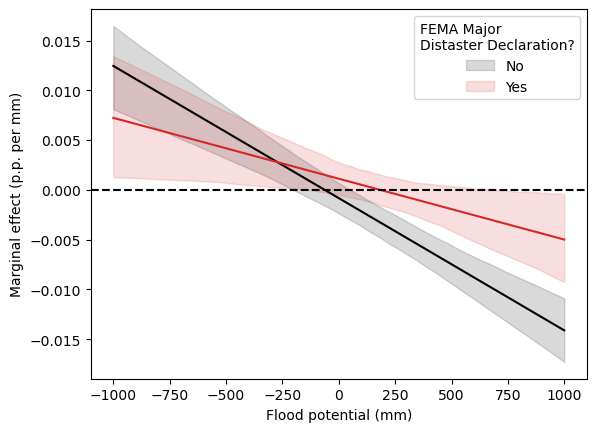

In [131]:
fig,ax=plt.subplots()
ax.plot(fp,me_nodd.mean(axis=0),color='black')
ax.fill_between(fp,np.quantile(me_nodd,0.025,axis=0),np.quantile(me_nodd,0.975,axis=0),color='black',alpha=0.15,label='No')
ax.plot(fp,me_dd.mean(axis=0),color='tab:red')
ax.fill_between(fp,np.quantile(me_dd,0.025,axis=0),np.quantile(me_dd,0.975,axis=0),color='tab:red',alpha=0.15,label='Yes')
ax.axhline(0,color='black',linestyle='--')
ax.legend(title='FEMA Major\nDistaster Declaration?')
ax.set_xlabel("Flood potential (mm)")
ax.set_ylabel("Marginal effect (p.p. per mm)")

In [ ]:
# mod_rx1d = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rx1d+np.power(rx1d, 2)+i(county,year)|county + year",data=mod_mat)
mod_rx1d.coef()['rx1d']/-2/mod_rx1d.coef()['np.power(rx1d, 2)']

In [ ]:
mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon+p_exc_rxmon_sq+i(county,year)|county + year",data=mod_mat)
# mod.summary()

In [ ]:
mod.vcov({"CRV1":"state"}).summary()

In [ ]:
mod.coef()['rx1d']/-2/mod.coef()['np.power(rx1d, 2)']

In [ ]:
mod_base.coef()['p_exc_rxmon']/-2/mod_base.coef()['p_exc_rxmon_sq']

In [251]:
sep_bs = []
counties = mod_mat['county'].unique()
n_counties = len(counties)

for b in range(1000):
    county_samp = np.random.choice(counties,n_counties)
    samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rxmon*tws_def_pre_pexcmax+rxmon_sq|county + year",data=samp_mat)
    sep_bs.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
sep_bs = pd.concat(sep_bs,axis=1)
sep_bs.columns=np.arange(1000)+1
sep_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se','sep.csv'))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [252]:
lag1_sep_bs = []
counties = mod_mat['county'].unique()
n_counties = len(counties)

for b in range(1000):
    county_samp = np.random.choice(counties,n_counties)
    samp_mat = mod_mat[mod_mat.county.isin(county_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rxmon*tws_def_pre_pexcmax+rxmon_sq+rxmon_lag1*tws_def_pre_pexcmax_lag1+rxmon_sq_lag1|county + year",data=samp_mat)
    lag1_sep_bs.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
lag1_sep_bs = pd.concat(lag1_sep_bs,axis=1)
lag1_sep_bs.columns=np.arange(1000)+1
lag1_sep_bs.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','prism-rain_clsm-grace','county_se','sep_lag1.csv'))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


# 

In [260]:
lag1_sep_bs.index

Index(['ppt_ann', 'ppt_ann_sq', 'tmean', 'tmean_sq', 'rxmon',
       'tws_def_pre_pexcmax', 'rxmon_sq', 'rxmon_lag1',
       'tws_def_pre_pexcmax_lag1', 'rxmon_sq_lag1',
       'rxmon:tws_def_pre_pexcmax', 'rxmon_lag1:tws_def_pre_pexcmax_lag1'],
      dtype='object', name='Coefficient')

In [32]:
sep_bs_state = []
states = mod_mat['state'].unique()
n_states = len(states)

for b in range(1000):
    state_samp = np.random.choice(states,n_states)
    samp_mat = mod_mat[mod_mat.state.isin(state_samp)]
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rxmon*tws_def_pre_pexcmax+rxmon_sq|county+ year",data=samp_mat)
    sep_bs_state.append(mod.coef())
    if b>0 and b%50==0:
        print(b)
sep_bs_state = pd.concat(sep_bs_state,axis=1)
sep_bs_state.columns=np.arange(1000)+1
sep_bs_state.to_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','rain','state_se','sep.csv'))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


<Axes: >

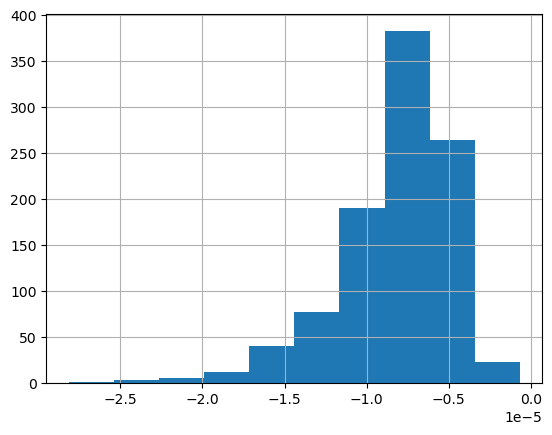

In [33]:
sep_bs_state.loc['rxmon_sq'].hist()

<Axes: >

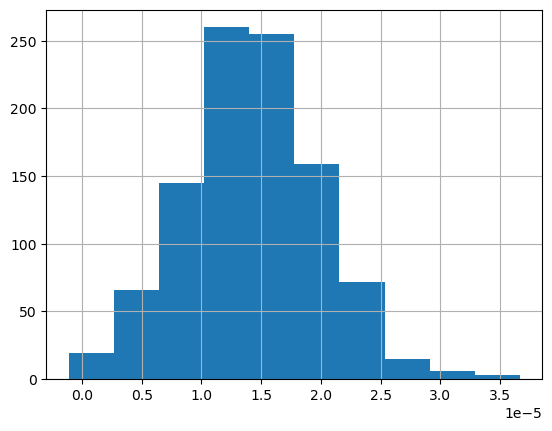

In [34]:
sep_bs_state.loc['rxmon:tws_def_pre_pexcmax'].hist()

In [ ]:
sep_bs_state.mean(axis=1)

In [35]:
# mod_sep = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rxmon*tws_def_pre_pexcmax+rxmon_sq|county + year",data=mod_mat)
# coef = mod_sep.coef()
coef = lag1_sep_bs.mean(axis=1)
ps = np.arange(0,1001,10)
ts = np.arange(0,1001,10)
me0 = np.empty((len(ps),len(ts)))
me1 = np.empty((len(ps),len(ts)))
for i,p in enumerate(ps):
    for j,t in enumerate(ts):
        me0[i,j] = coef['rxmon']+2*p*coef['rxmon_sq']+t*coef['rxmon:tws_def_pre_pexcmax']
        me1[i,j] = coef['rxmon_lag1']+2*p*coef['rxmon_sq_lag1']+t*coef['rxmon_lag1:tws_def_pre_pexcmax_lag1']

In [45]:
lag1_sep_bs

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
Coefficient,,,,,,,,,,,,,,,,,,,,,
ppt_ann,9.865109e-06,-1.016043e-04,1.429771e-03,4.404814e-04,9.533908e-04,1.001245e-03,1.046971e-03,6.383478e-05,3.156061e-04,9.538183e-04,...,-5.838785e-05,-3.314915e-04,-4.852374e-04,1.397193e-04,4.606843e-04,8.588418e-04,5.696430e-04,6.011480e-04,1.144999e-04,7.643882e-04
ppt_ann_sq,1.492803e-07,1.430674e-07,-3.358681e-07,-9.104363e-08,-1.785054e-07,-3.750795e-07,-3.143032e-07,9.118807e-08,-1.127394e-07,-1.616317e-07,...,1.050652e-07,1.926415e-07,2.325792e-07,5.260150e-08,-3.332863e-08,-1.453549e-07,-1.298428e-07,-1.058995e-07,5.428854e-08,-1.623360e-07
tmean,-3.917344e-01,-7.480566e-01,-5.368959e-01,-5.096492e-01,-5.738732e-01,-4.249684e-01,-4.839259e-01,-5.819119e-01,-5.184888e-01,-5.410727e-01,...,-4.998833e-01,-4.984880e-01,-4.805325e-01,-5.074166e-01,-5.952212e-01,-4.238846e-01,-6.616189e-01,-4.058997e-01,-6.689824e-01,-7.509079e-01
tmean_sq,3.341763e-02,4.551085e-02,3.987318e-02,3.841062e-02,4.108974e-02,3.953872e-02,3.395414e-02,4.071541e-02,4.046848e-02,4.022718e-02,...,3.872747e-02,4.212451e-02,3.967510e-02,3.529608e-02,4.155016e-02,3.547493e-02,4.045304e-02,3.549148e-02,4.295673e-02,5.082143e-02
rxmon,2.886657e-03,3.154451e-03,2.254316e-03,3.737131e-03,4.140969e-04,2.419819e-03,2.883063e-03,3.659629e-03,2.481990e-03,1.271337e-03,...,1.390204e-03,4.028248e-03,4.119971e-03,2.229151e-03,2.513880e-03,2.520107e-03,1.902921e-03,1.201887e-03,1.132112e-03,3.729190e-04
tws_def_pre_pexcmax,-7.354904e-03,-6.740801e-03,-6.560709e-03,-6.037199e-03,-6.599337e-03,-7.021308e-03,-5.562894e-03,-7.956468e-03,-7.953658e-03,-6.982013e-03,...,-5.677279e-03,-6.107692e-03,-8.615349e-03,-7.035790e-03,-6.754035e-03,-7.033085e-03,-7.198384e-03,-7.895855e-03,-7.596215e-03,-7.078958e-03
rxmon_sq,-1.057620e-05,-1.230385e-05,-1.141451e-05,-8.766283e-06,-8.237906e-06,-7.153498e-06,-9.371610e-06,-1.425185e-05,-1.006005e-05,-8.638381e-06,...,-7.050692e-06,-1.018178e-05,-1.484727e-05,-1.051821e-05,-1.106561e-05,-1.241172e-05,-1.068227e-05,-9.427434e-06,-8.638861e-06,-8.206833e-06
rxmon_lag1,6.797202e-04,-1.171447e-03,2.186443e-03,-1.429639e-04,8.352645e-04,-8.207184e-04,4.607646e-05,-4.618729e-04,-1.635026e-03,-1.528620e-03,...,-6.724754e-05,-7.144131e-04,-5.624129e-04,-1.572463e-03,-1.536494e-03,-5.631044e-04,-9.723011e-04,-1.607624e-03,-2.208296e-03,-1.275715e-03
tws_def_pre_pexcmax_lag1,8.136990e-03,6.928953e-03,6.189887e-03,7.588121e-03,7.277432e-03,6.261243e-03,5.776656e-03,8.172520e-03,8.206874e-03,7.823246e-03,...,6.585668e-03,5.990767e-03,7.458530e-03,6.662736e-03,7.135066e-03,7.714416e-03,7.686972e-03,8.382716e-03,6.778026e-03,8.121902e-03


<Axes: ylabel='Frequency'>

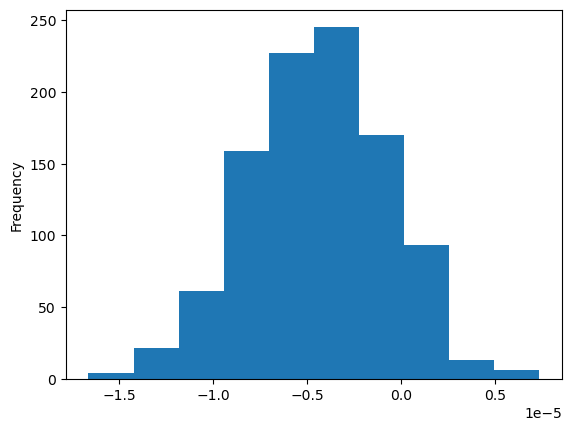

In [46]:
(lag1_sep_bs.loc['rxmon:tws_def_pre_pexcmax']+lag1_sep_bs.loc['rxmon_lag1:tws_def_pre_pexcmax_lag1']).plot.hist()

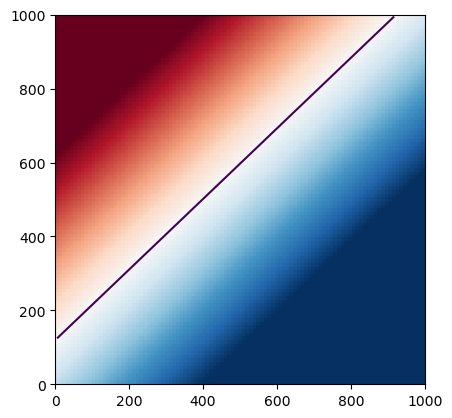

In [37]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.imshow(me0,origin='lower',cmap='RdBu',vmin=-0.01,vmax=0.01,extent=[0,1000,0,1000])
ax.contour(me0,levels=[0],origin='lower',extent=[0,1000,0,1000])
# ax.plot([0,1000-109],[109,1000])

In [ ]:
me0

In [ ]:
np.quantile(me0+me1,0,

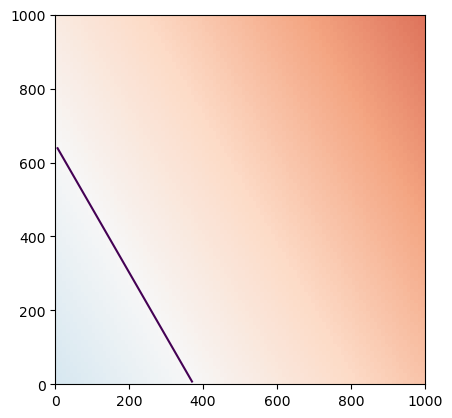

In [36]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.imshow(me0+me1,origin='lower',cmap='RdBu',vmin=-0.01,vmax=0.01,extent=[0,1000,0,1000])
ax.contour(me0+me1,levels=[0],origin='lower',extent=[0,1000,0,1000])
# ax.plot([0,1000-109],[109,1000])

In [ ]:
mod_lag1 = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+rxmon*tws_def_pre_pexcmax+rxmon_sq+rxmon_lag1*tws_def_pre_pexcmax_lag1+rxmon_sq_lag1 |county + year",data=mod_mat)
coef_lag1 = mod_lag1.coef()
ps = np.arange(0,1001,10)
ts = np.arange(0,1001,10)
me_lag0 = np.empty((len(ps),len(ts)))
me_lag1 = np.empty((len(ps),len(ts)))
for i,p in enumerate(ps):
    for j,t in enumerate(ts):
        me_lag0[i,j] = coef_lag1['rxmon']+2*p*coef_lag1['rxmon_sq']+t*coef_lag1['rxmon:tws_def_pre_pexcmax']
        me_lag1[i,j] = coef_lag1['rxmon_lag1']+2*p*coef_lag1['rxmon_sq_lag1']+t*coef_lag1['rxmon_lag1:tws_def_pre_pexcmax_lag1']

In [ ]:
plt.plot(ts,me_lag0[30])
plt.plot(ts,me_lag0[30]+me_lag1[30])

In [ ]:
plt.imshow(me_lag0,origin='lower',cmap='RdBu',vmin=-0.01,vmax=0.01,extent=[0,1000,0,1000])

In [ ]:
plt.imshow(me_lag0+me_lag1,origin='lower',cmap='RdBu',vmin=-0.01,vmax=0.01,extent=[0,1000,0,1000])

In [ ]:
plt.plot(ps,mod.coef()['p_exc_rxmon']+2*ps*mod.coef()['p_exc_rxmon_sq'])

In [ ]:
mod_dis_dec = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon+p_exc_rxmon_sq)*C(flood_decl)+i(county,year)|county + year",data=mod_mat)
coef = mod_dis_dec.coef()
import matplotlib.pyplot as plt
ps = np.arange(-1000,1001,20)
plt.plot(ps,coef['p_exc_rxmon']+2*ps*coef['p_exc_rxmon_sq'])
plt.plot(ps,coef['p_exc_rxmon']+coef['p_exc_rxmon:C(flood_decl)[T.1.0]']+2*ps*coef['p_exc_rxmon_sq']+2*ps*coef['p_exc_rxmon_sq:C(flood_decl)[T.1.0]'])
plt.show()

In [ ]:
mod_dis_dec_lag1 = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+(p_exc_rxmon_lag0+p_exc_rxmon_sq_lag0+p_exc_rxmon_lag1+p_exc_rxmon_sq_lag1)*C(flood_decl)+i(county,year)|county + year",data=mod_mat)


In [ ]:
coef_lag1 = mod_dis_dec_lag1.coef()

In [ ]:
lag0 = coef_lag1['p_exc_rxmon_lag0']+2*ps*coef_lag1['p_exc_rxmon_sq_lag0']
lag1 = lag0 + coef_lag1['p_exc_rxmon_lag1']+2*ps*coef_lag1['p_exc_rxmon_sq_lag1']
lag2 = lag1 + coef_lag1['p_exc_rxmon_lag2']+2*ps*coef_lag1['p_exc_rxmon_sq_lag2']


In [ ]:
plt.plot(ps,lag0)
plt.plot(ps,lag1)
plt.plot(ps,lag2)

In [ ]:
import matplotlib.pyplot as plt
ps = np.arange(-1000,1001,20)
no_dec_lag0 = coef_lag1['p_exc_rxmon_lag0']+2*ps*coef_lag1['p_exc_rxmon_sq_lag0']
dec_lag0 = no_dec_lag0 + coef_lag1['p_exc_rxmon_lag0:C(flood_decl)[T.1.0]']+2*ps*coef_lag1['p_exc_rxmon_sq_lag0:C(flood_decl)[T.1.0]']

no_dec_lag1 = no_dec_lag0 + coef_lag1['p_exc_rxmon_lag1']+2*ps*coef_lag1['p_exc_rxmon_sq_lag1']
dec_lag1 = dec_lag0 + coef_lag1['p_exc_rxmon_lag1']+2*ps*coef_lag1['p_exc_rxmon_sq_lag1']+ coef_lag1['p_exc_rxmon_lag1:C(flood_decl)[T.1.0]']+2*ps*coef_lag1['p_exc_rxmon_sq_lag1:C(flood_decl)[T.1.0]']

plt.plot(ps,no_dec_lag0)
# plt.plot(ps,dec_lag0)
plt.plot(ps,no_dec_lag1)
plt.show()

In [ ]:
plt.plot(ps,dec_lag0)
# plt.plot(ps,dec_lag0)
plt.plot(ps,dec_lag1)
plt.show()

In [ ]:
for s in mod_mat['state'].unique():
    mod = pf.feols("growth~ppt_ann+ppt_ann_sq+tmean+tmean_sq+p_exc_rxmon+p_exc_rxmon_sq+i(county,year)|county + year",data=mod_mat[mod_mat.state!=s])
    coef = mod.coef()
    pval = mod.pvalue()
    print(s,coef['p_exc_rxmon'],pval['p_exc_rxmon'],coef['p_exc_rxmon_sq'],pval['p_exc_rxmon_sq'],coef['p_exc_rxmon']/-2/coef['p_exc_rxmon_sq'])

In [ ]:
mod_mat.sort_values("p_exc_rxmon",ascending=False).head(50)

In [ ]:
coef = mod.coef()
import matplotlib.pyplot as plt
ps = np.arange(-500,501)
plt.plot(ps,ps*coef['p_exc_rxmon']+(ps**2)*coef['p_exc_rxmon_sq'])

In [ ]:
coef['p_exc_rxmon']/-2/coef['p_exc_rxmon_sq']